# Getting Started with OpenAi and CartPole

## Installation

To get rendering to work, I needed to install pyglet version 1.2.4 (I think that's a downgrade). I found some nice code [here](http://mckinziebrandon.me/TensorflowNotebooks/2016/12/21/openai.html) for visualization in Jupyter notebook, which requires JSAnimation.

In [1]:
#!pip install pyglet==1.2.4
#!pip install gym
#!pip install JSAnimation

In [2]:
import numpy as np
import gym

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display
%matplotlib inline

## Basics

We will learn to play the [CartPole](https://www.youtube.com/watch?v=J7E6_my3CHk) game. In the game we can move a cart to the left or to the right, and we try to balance the pole that is placed on it. 
![](cartpole)

We get a reward of +1 for every time-step. The game ends if the pole is more than 15 degrees from vertical, or if the cart moves at least 2.4 units from center.

In [3]:
env = gym.make('CartPole-v0')  # We create our game environment

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Every environment has an observation space and an action space. The former contains the observations that describe the state the game is in, and the latter available actions.

In [4]:
print(env.observation_space)
print(env.action_space)

Box(4,)
Discrete(2)


For CartPole, each state is described with a 4 dimensional vector, giving the cart position, cart velocity, pole angle, and pole tip velocity.

The action space has two possibilities: to apply some force to the left (0) or to the right (1).

In [5]:
s = env.reset()  # We reset it to the initial state. For CartPole, that is random.
print(s)

[-0.01133669 -0.02502698  0.010349    0.00610418]


Now we have our initial state and can take an action. We use the `env.step` function, supplying it with the action we take.

In [6]:
env.step(1)

(array([-0.01183723,  0.16994503,  0.01047108, -0.28329563]), 1.0, False, {})

We receive back a tuple containing:
1. A vector describing the next state
1. Our reward. In this case +1 if we are still in the game.
1. A boolean that is True if the game is over
1. Some diagnostic info for debugging

## Random Policy

A policy in this game is a function that maps a 4 dimensional input (describing the state) to a binary output (0 or 1).

Let's first implement a random strategy. At every time-step we randomly decide to go left or right.

In [7]:
s = env.reset()
for i in range(200):
    action = env.action_space.sample()
    s, reward, done, _ = env.step(action)
    if done:
        break
print(f'Total number of time-steps: {i}')

Total number of time-steps: 15


## Visualizing CartPole

It is nice to see our policy in action. We can use `env.render()` to do so in a separate window as we run the code. The window will only be available during run-time though.

Fortunately, we can also save the frames from our game, and generate a little animation in our Jupyter notebook. I'm borrowing [this](http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb) solution.

In [8]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    From http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total number of time-steps: 14



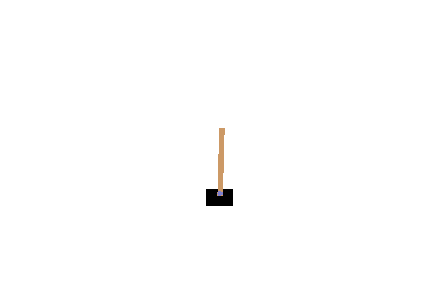
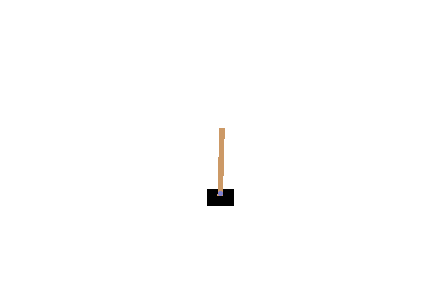
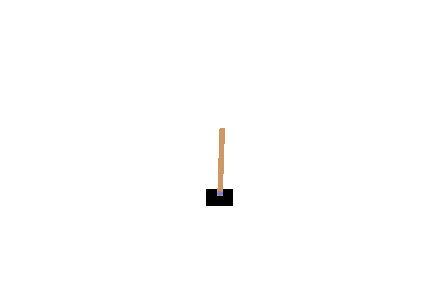
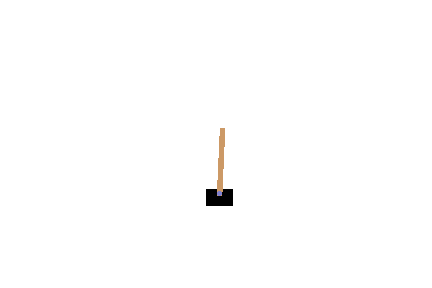
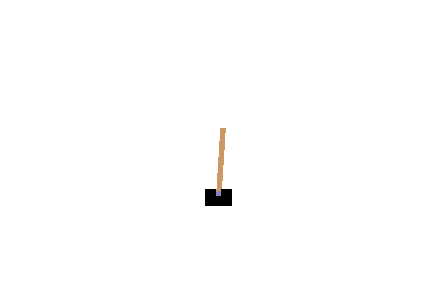
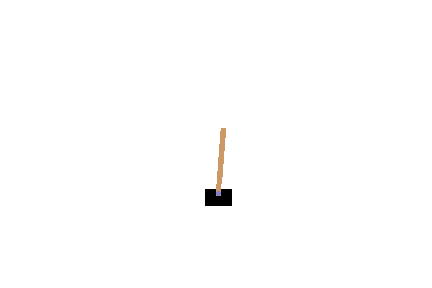
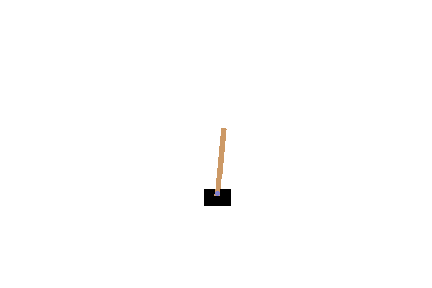
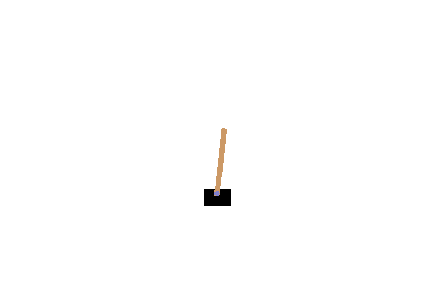
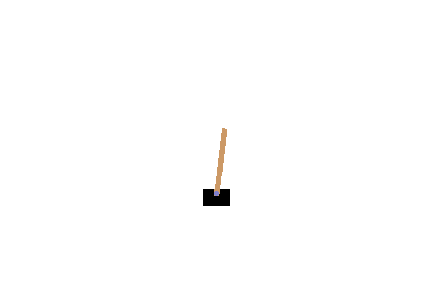
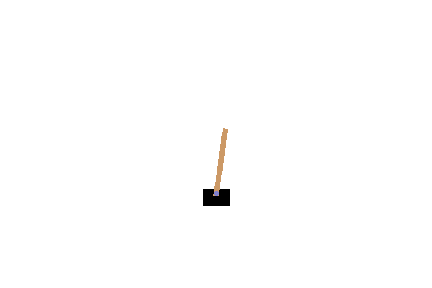
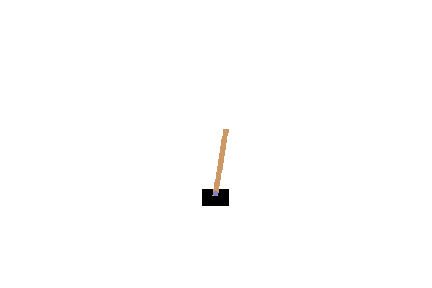
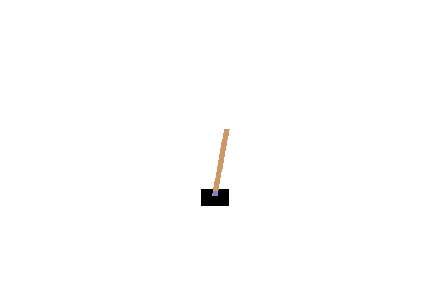
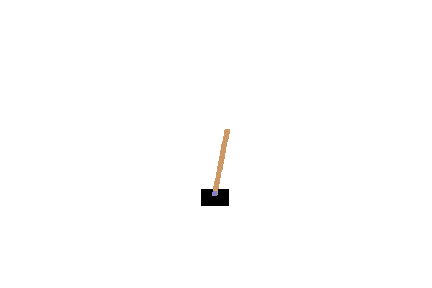
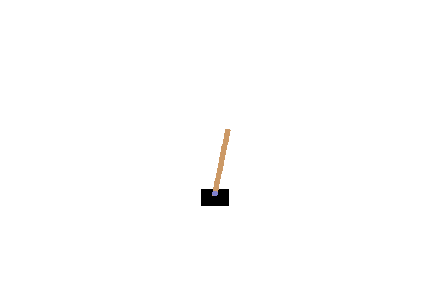
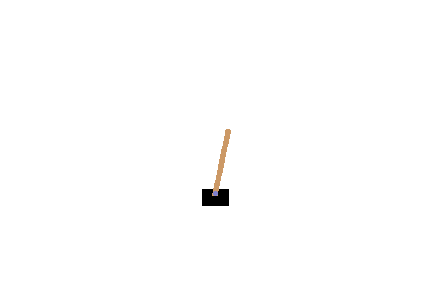

In [9]:
env = gym.make('CartPole-v0')  # I need to recreate this for render to work. No idea why.
s = env.reset()
frames = []
for i in range(200):
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    s, reward, done, _ = env.step(action)
    if done:
        break
env.close()
print(f'Total number of time-steps: {i}')
display_frames_as_gif(frames)

Now that we have a nice way to visualize our policy, it's time to improve on it a bit.

## Linear Decision Process

A simple way to make decisions is to take our 4-dimensional vector describing our current state and multiply it with some weights. If the resulting dot product is negative, we push left, otherwise, we push right. 

That is, given some learnable parameter vector $w$ and our state $s$:

if $ w^T s < 0$, we move left;

if $ w^T s >= 0$, we move right.

I took this approach from [here](http://kvfrans.com/simple-algoritms-for-solving-cartpole/), where you can read about it in more detail.

In [10]:
def LinearDecision(s, w):
    res = s @ w
    if res < 0:
        return 0
    else:
        return 1

Let's try it out with some random parameter values.

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total number of time-steps: 35



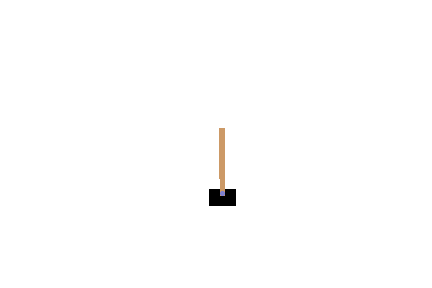
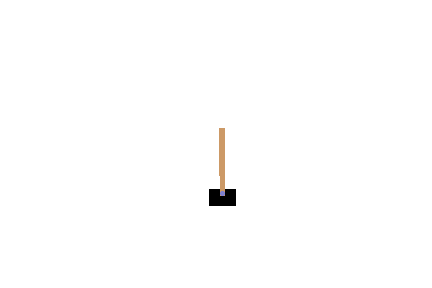
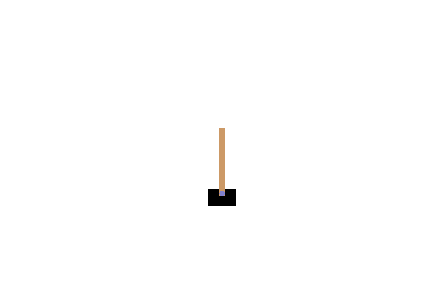
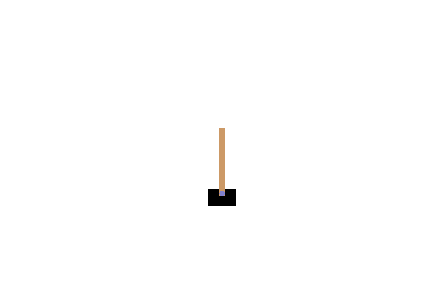
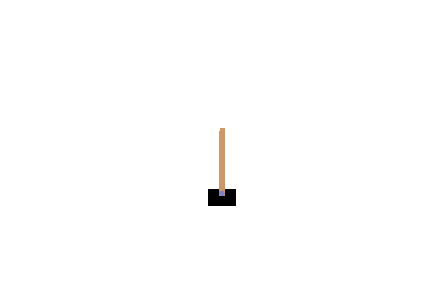
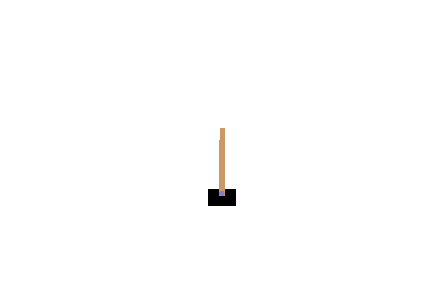
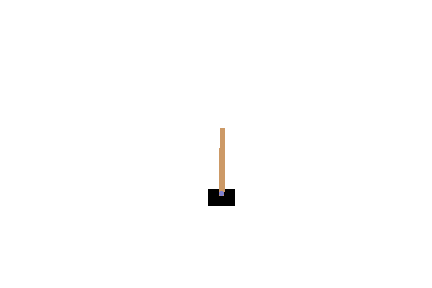
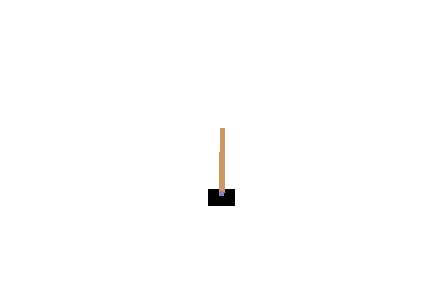
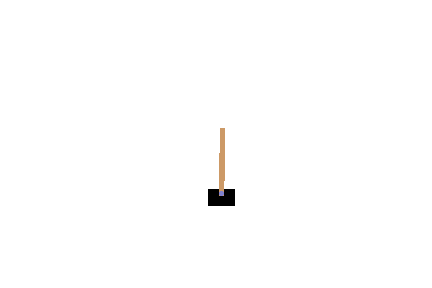
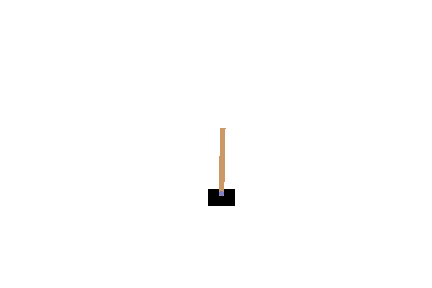
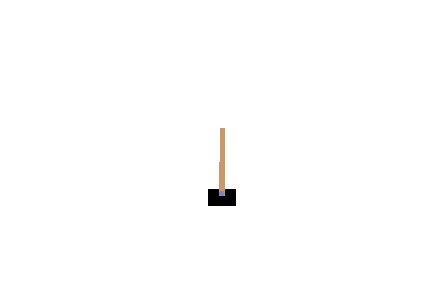
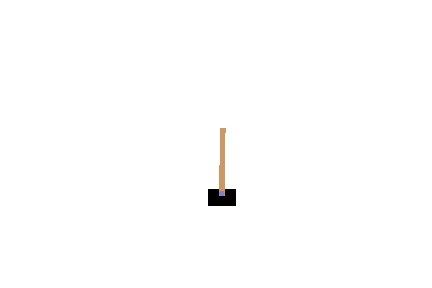
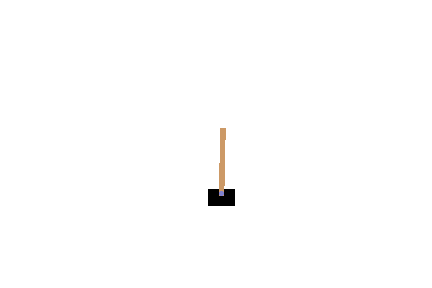
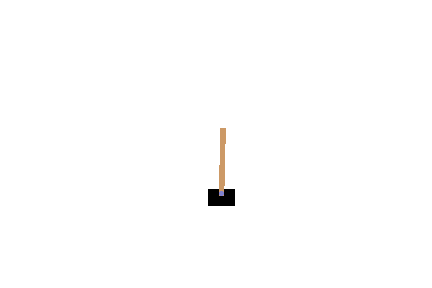
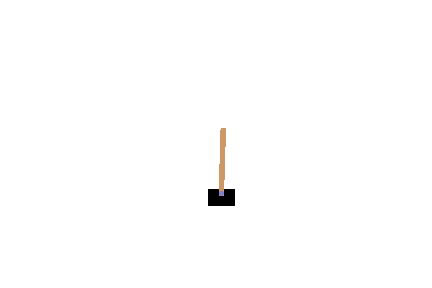
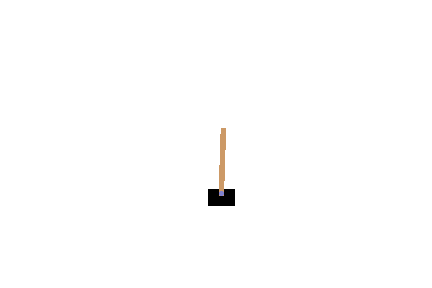
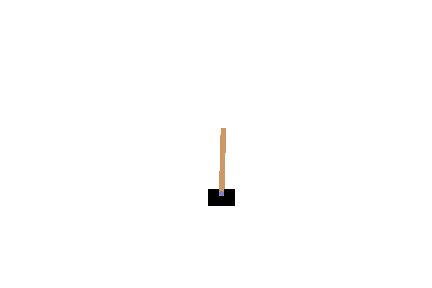
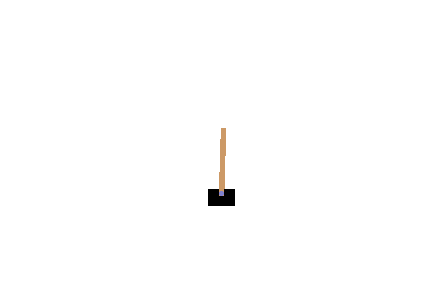
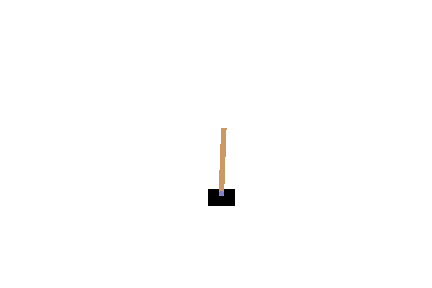
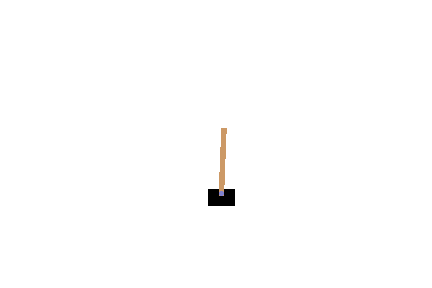
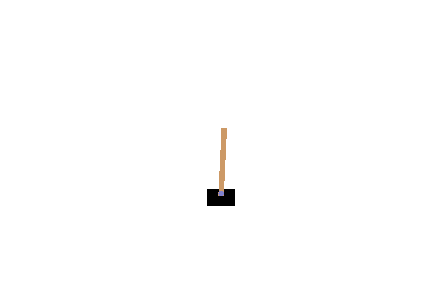
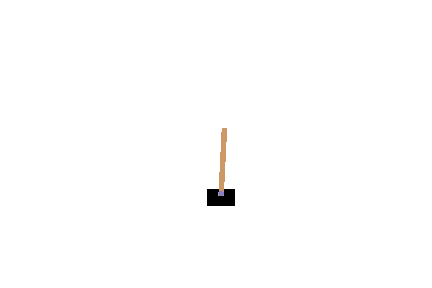
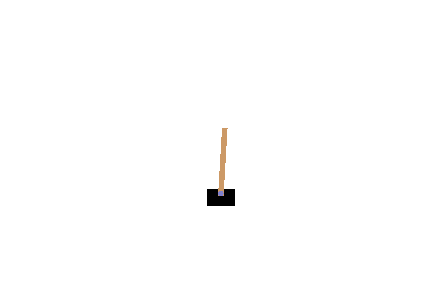
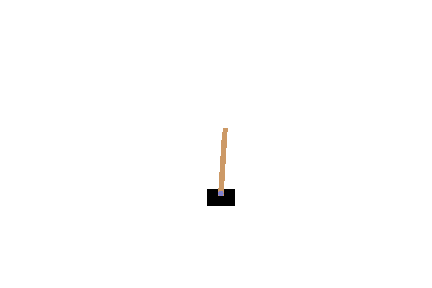
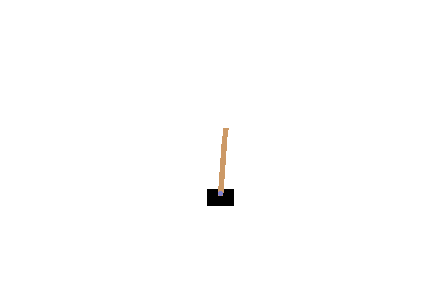
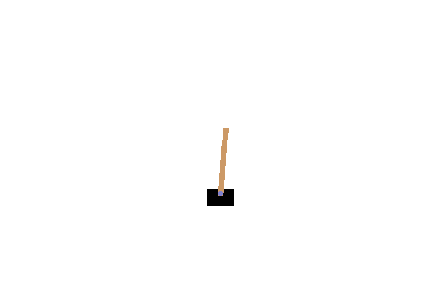
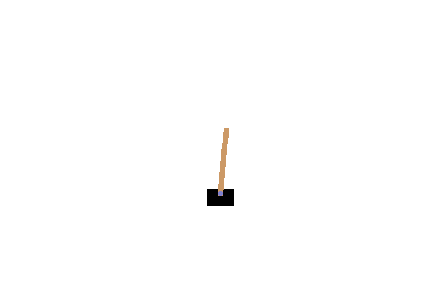
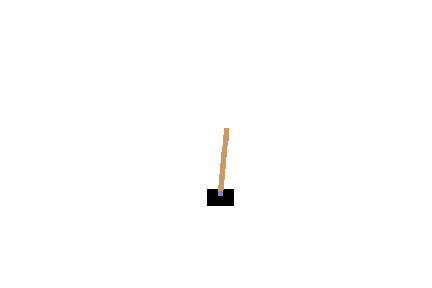
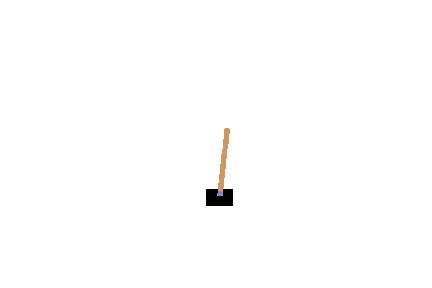
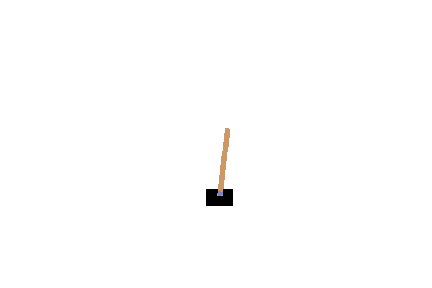
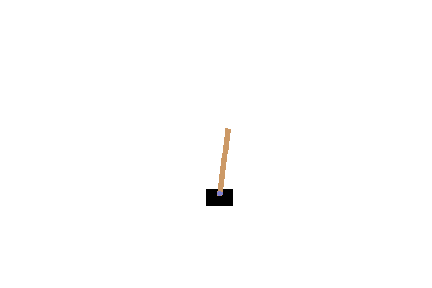
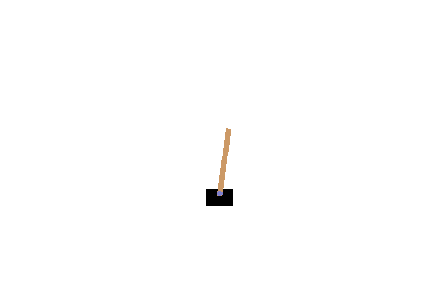
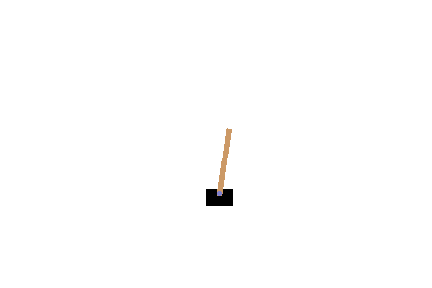
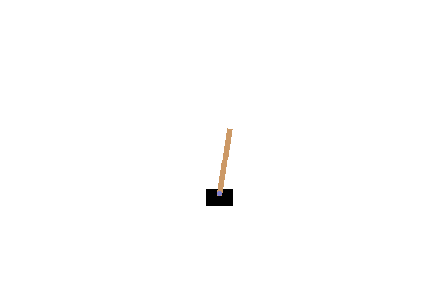
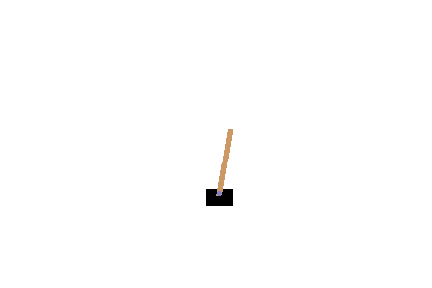
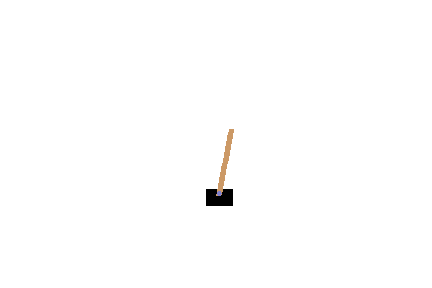

In [11]:
w = np.random.rand(4) * 2 - 1  # Between -1 and 1
env = gym.make('CartPole-v0')  # I need to recreate this for render to work. No idea why.
s = env.reset()
frames = []
for i in range(200):
    frames.append(env.render(mode = 'rgb_array'))
    action = LinearDecision(s, w)
    s, reward, done, _ = env.step(action)
    if done:
        break
env.close()
print(f'Total number of time-steps: {i}')
display_frames_as_gif(frames)

Okay, that's not very good yet. We have to find good values for our parameter $w$. How do we do that?

## Random Search over the Parameter Space

A simple way of getting better parameters is to try a number of different random parameter settings, run our game, and see which one performs best.

In [12]:
def simulateRun(env, w):
    s = env.reset()
    for i in range(200):
        action = LinearDecision(s, w)
        s, reward, done, _ = env.step(action)
        if done:
            return i
        
def randomSearch(n, multiple = 5):
    
    # If multiple >1, we run each weight multiple times, and record the worst outcome
    
    env = gym.make('CartPole-v0')
    ws = []
    res = []
    
    for i in range(n):
        w = np.random.rand(4) * 2 - 1
        temp_res = []
        for j in range(multiple):
            temp_res.append(simulateRun(env, w))     
        ws.append(w); res.append(min(temp_res))
    
    return (res, ws)  

res, ws = randomSearch(10000)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


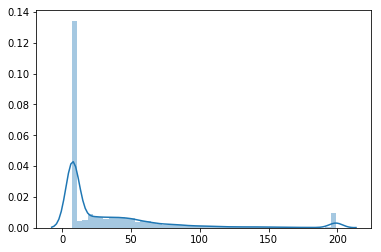

In [13]:
sns.distplot(res)

Okay, looks like we found some parameters that will play for almost 200 rounds.

In [14]:
max(res)

199

In [15]:
best_weights = ws[res.index(max(res))]
print(best_weights)

[0.37232605 0.33124164 0.74461116 0.90524721]


Let's simulate playing with these weights!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total number of time-steps: 199



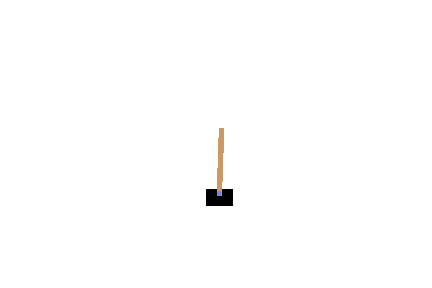
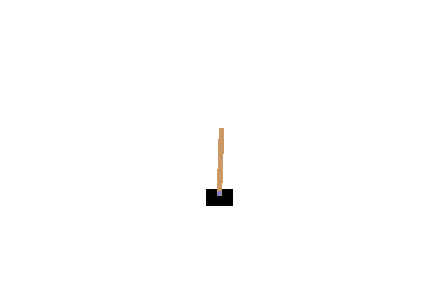
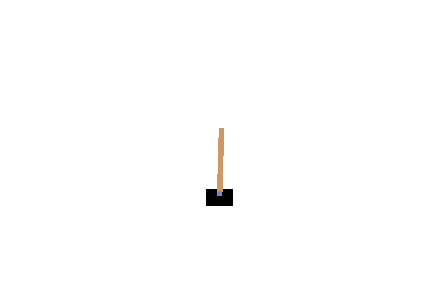
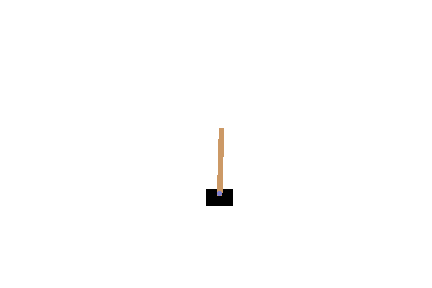
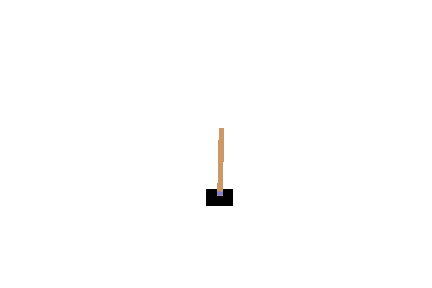
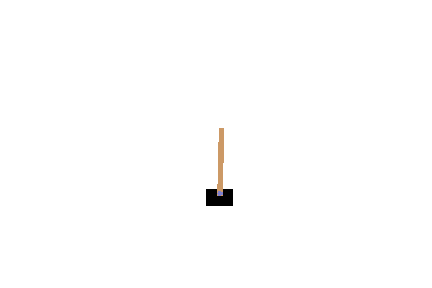
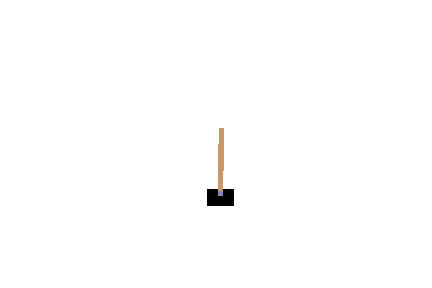
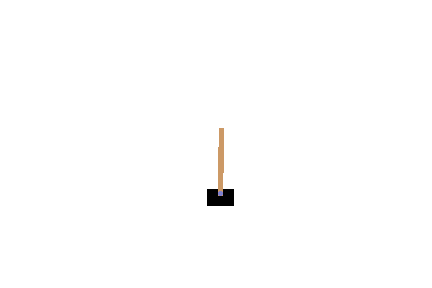
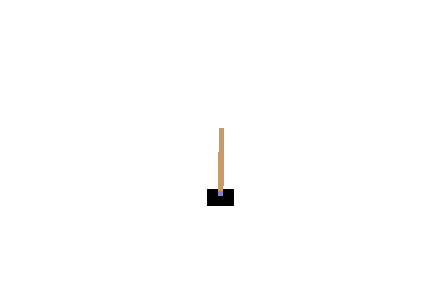
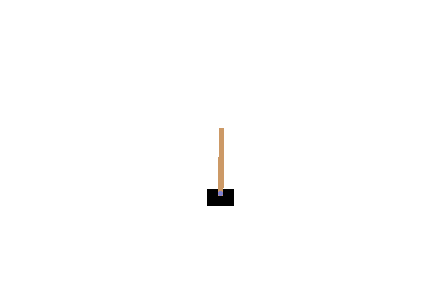
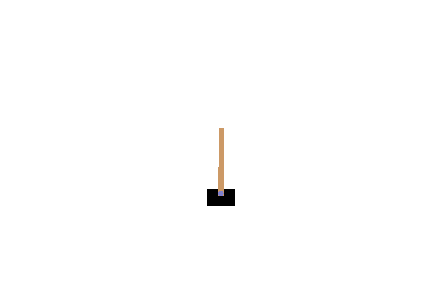
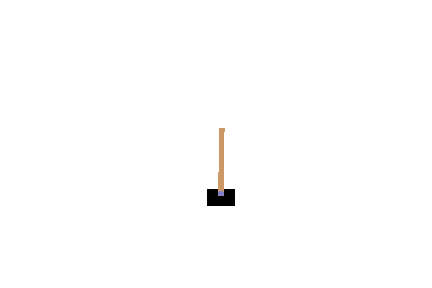
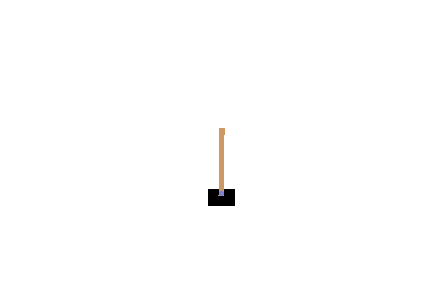
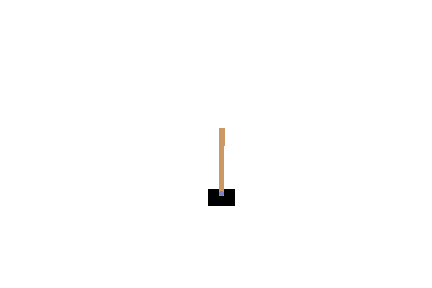
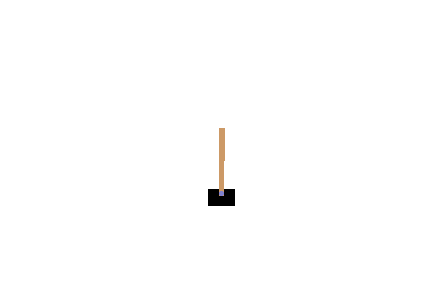
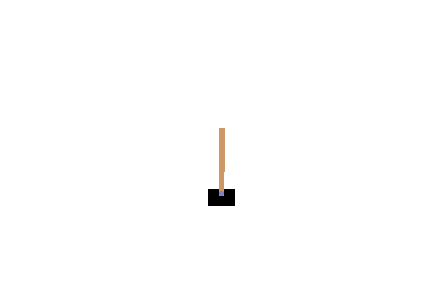
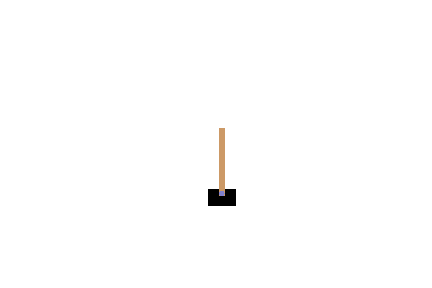
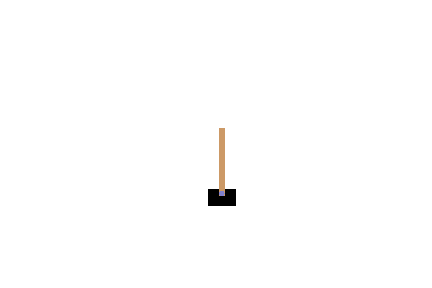
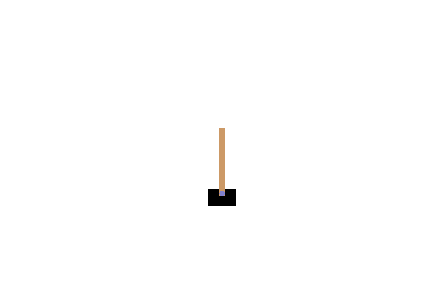
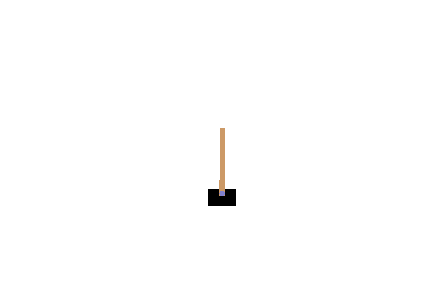
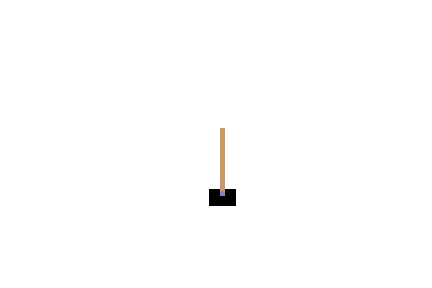
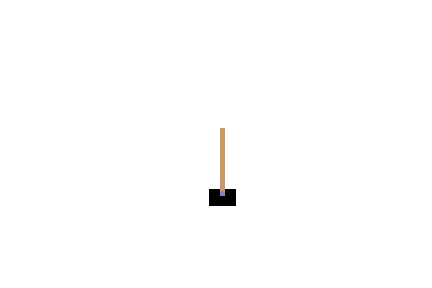
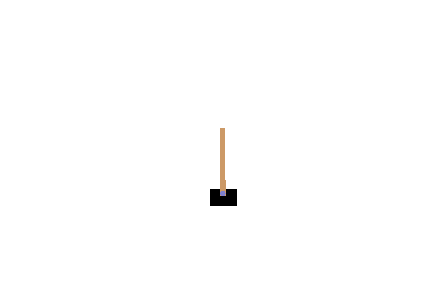
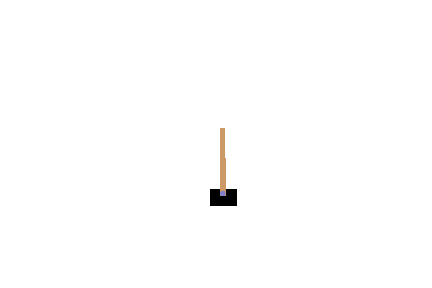
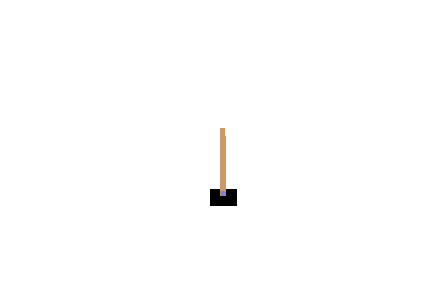
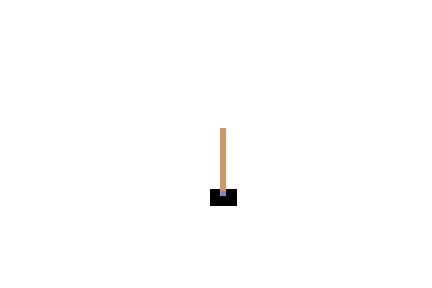
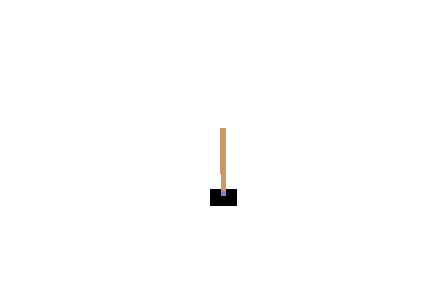
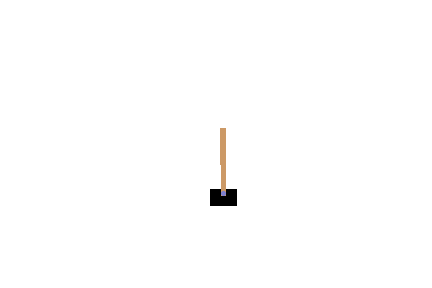
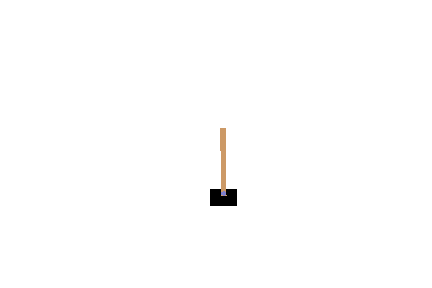
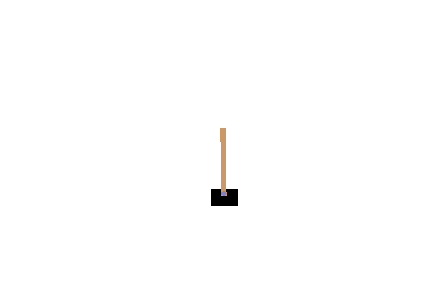
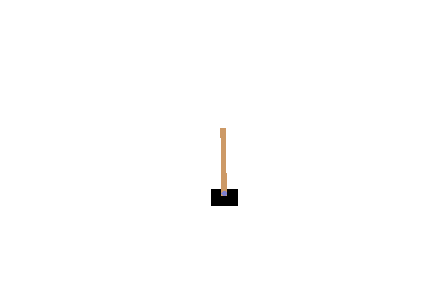
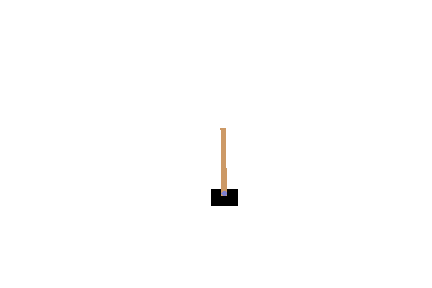
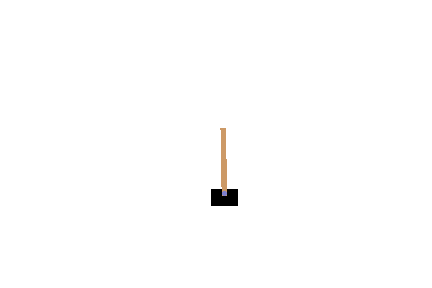
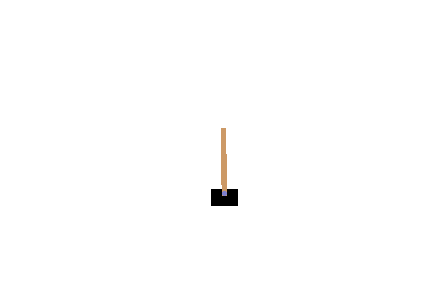
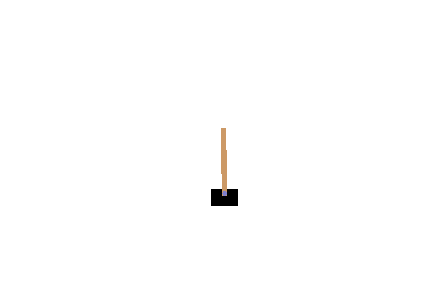
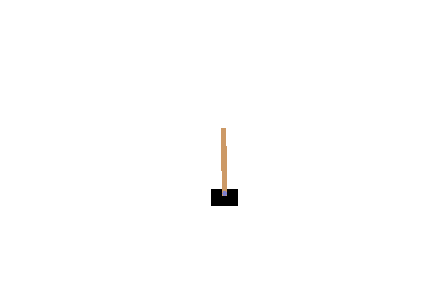
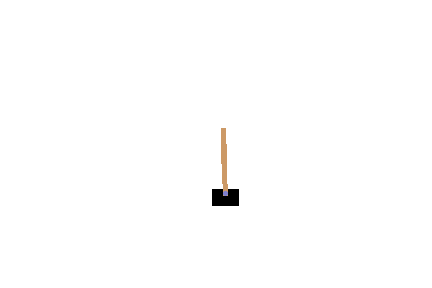
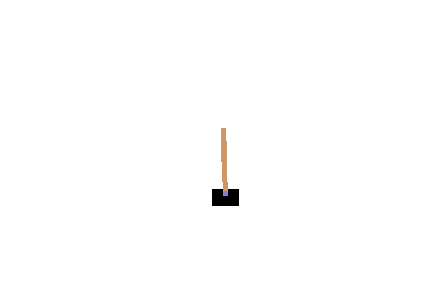
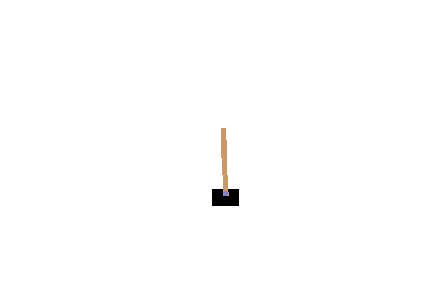
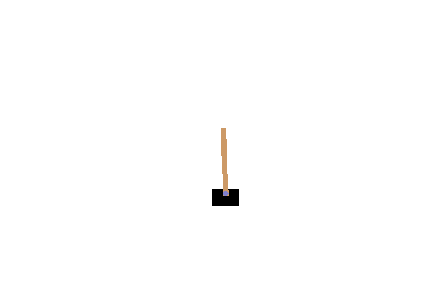
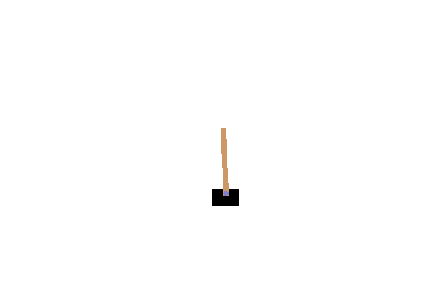
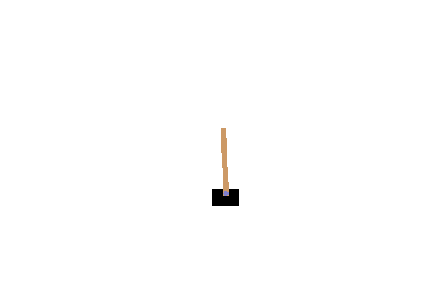
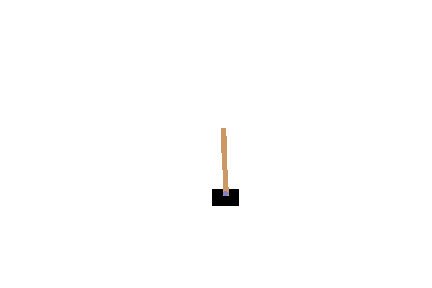
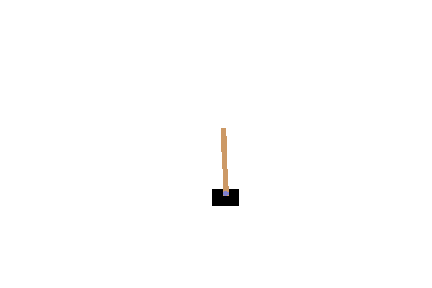
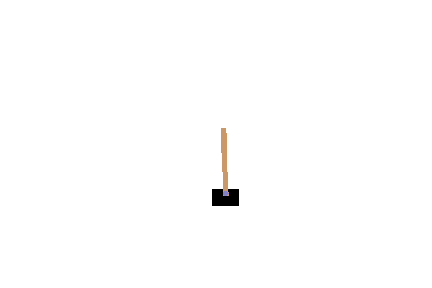
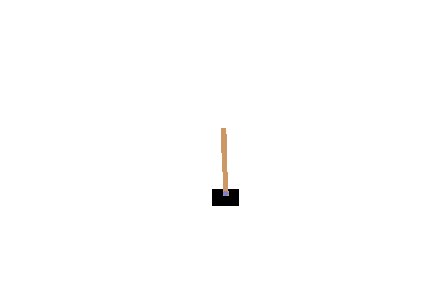
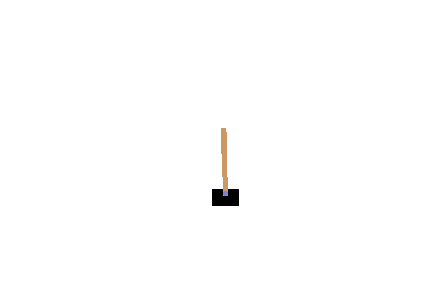
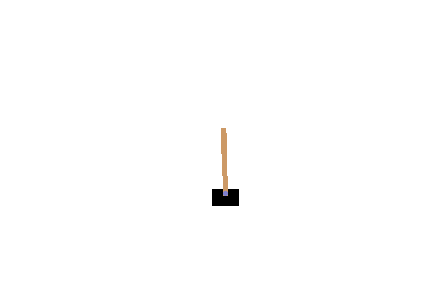
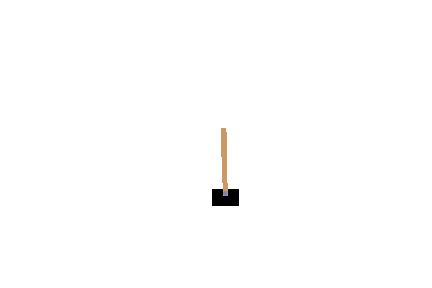
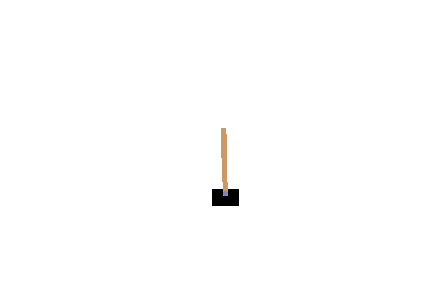
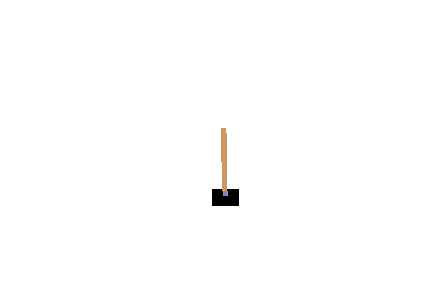
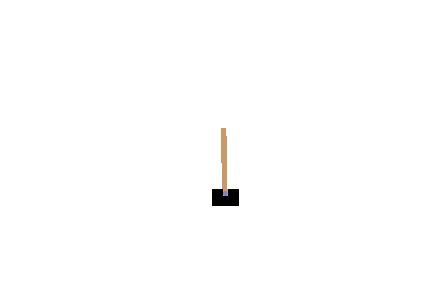
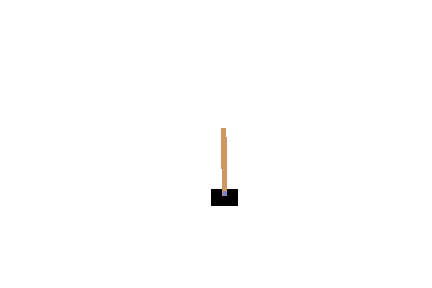
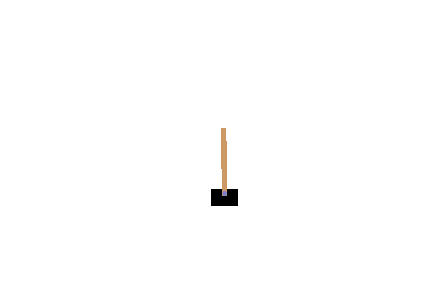
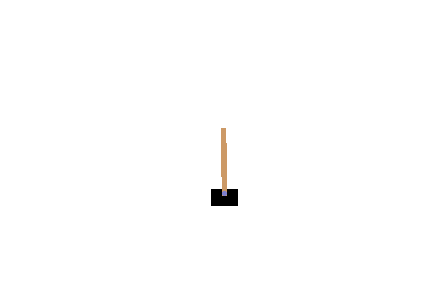
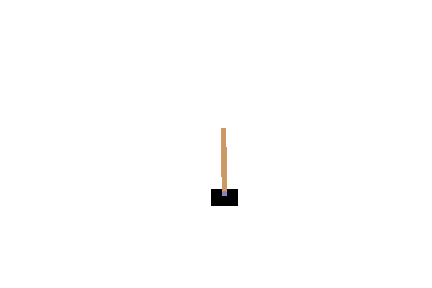
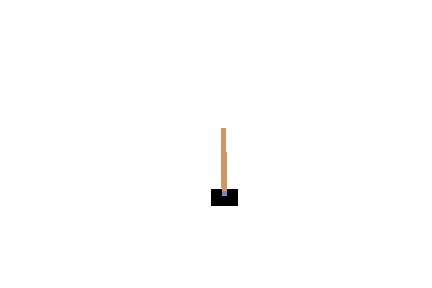
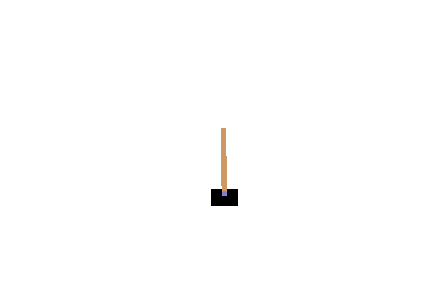
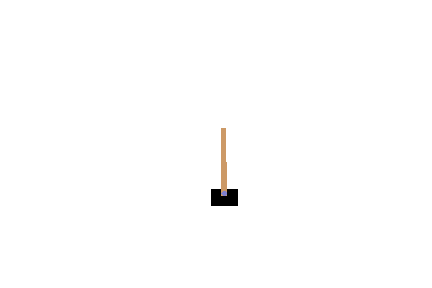
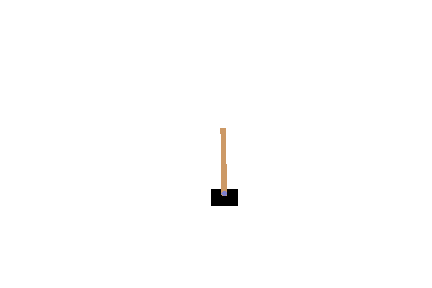
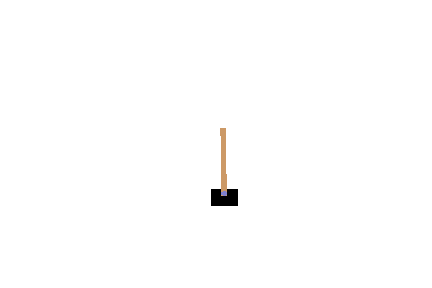
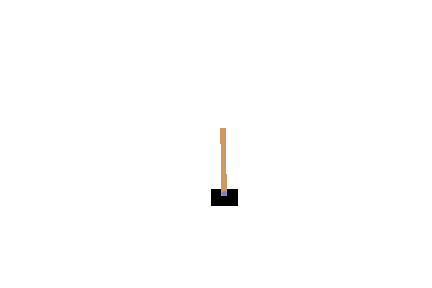
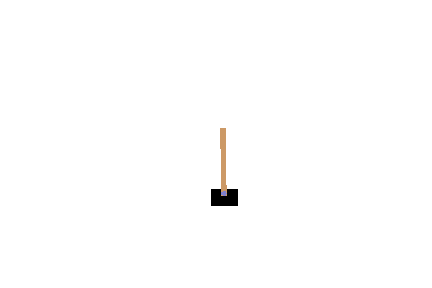
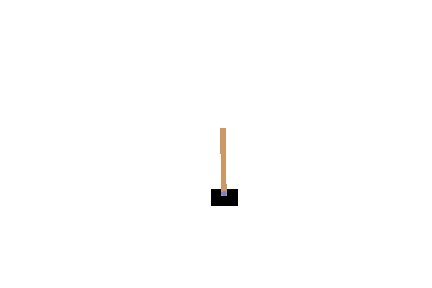
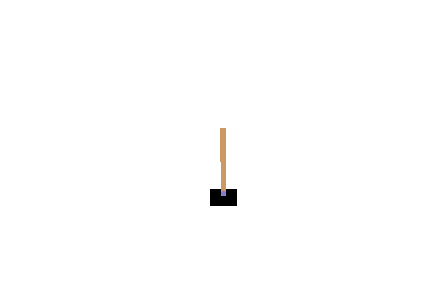
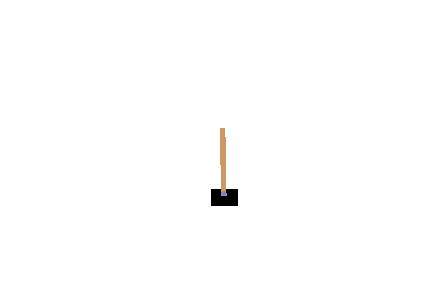
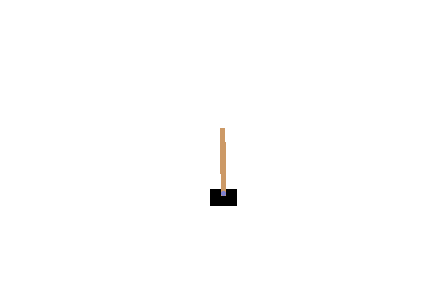
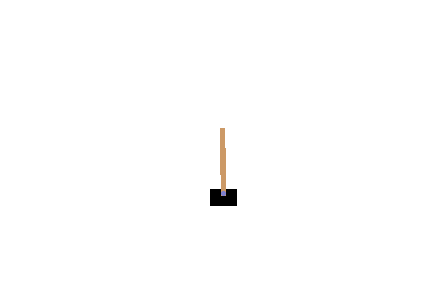
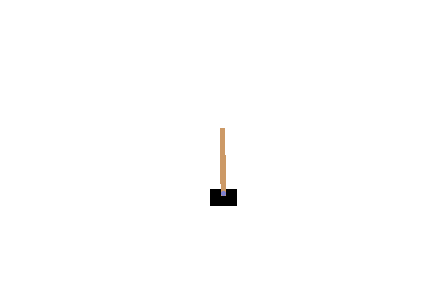
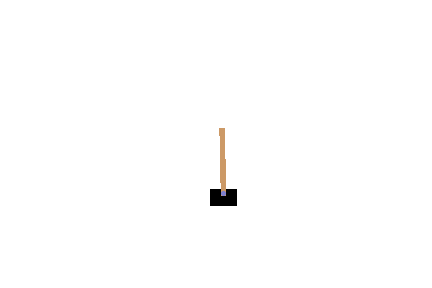
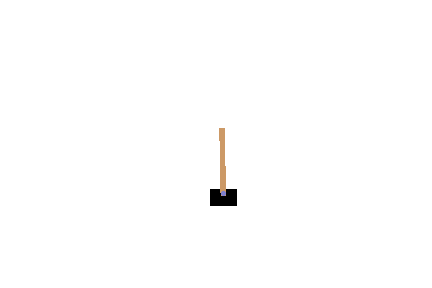
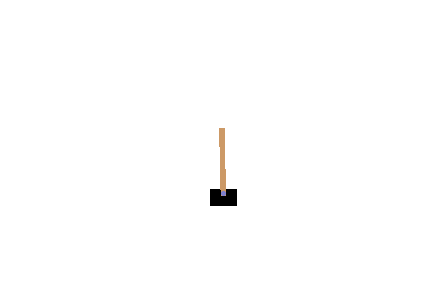
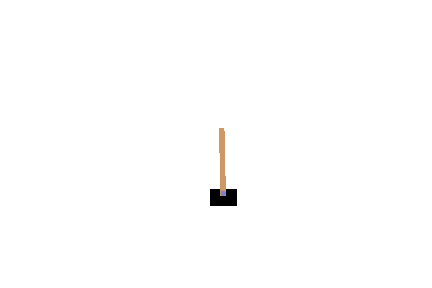
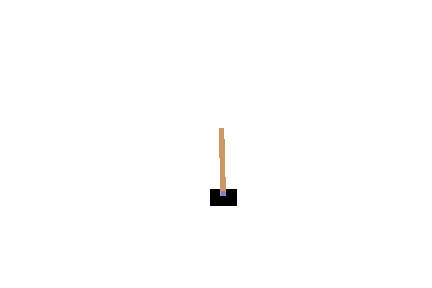
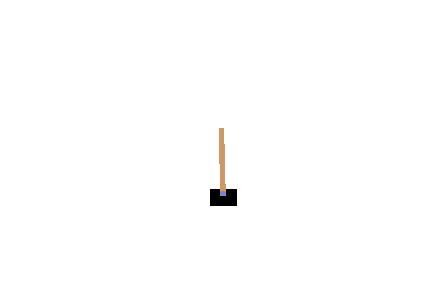
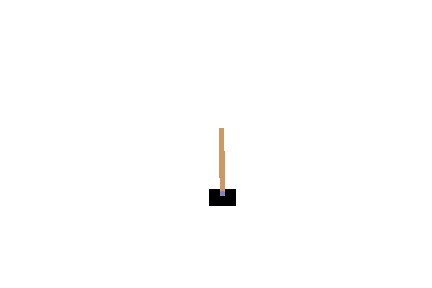
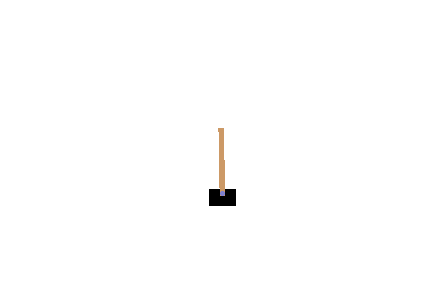
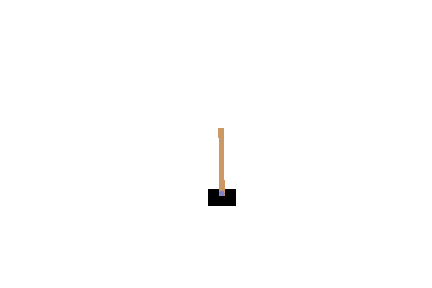
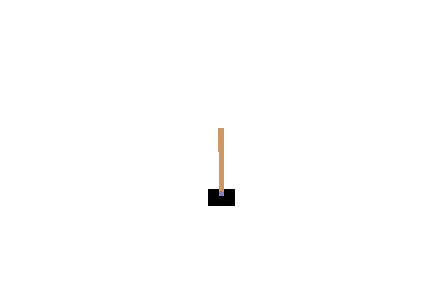
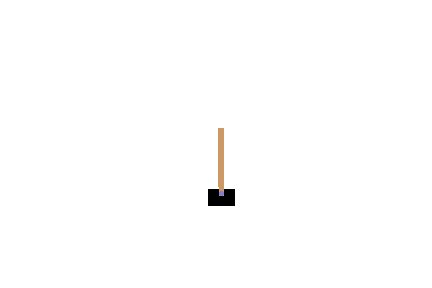
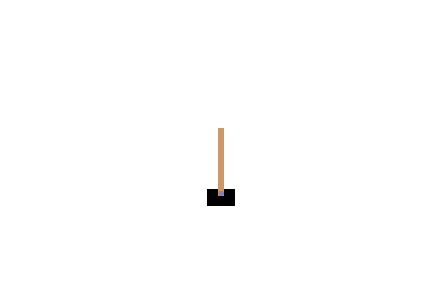
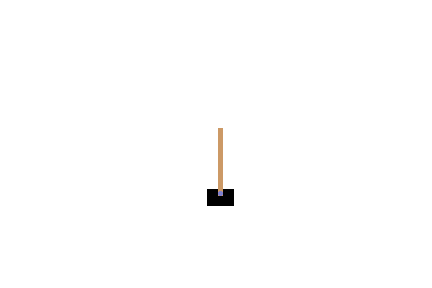
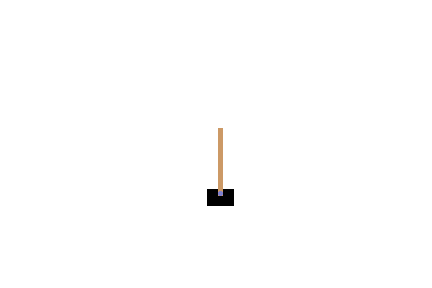
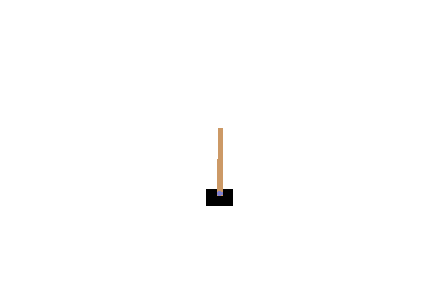
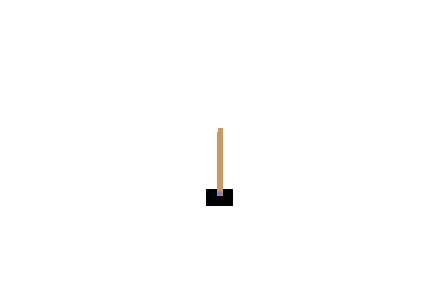
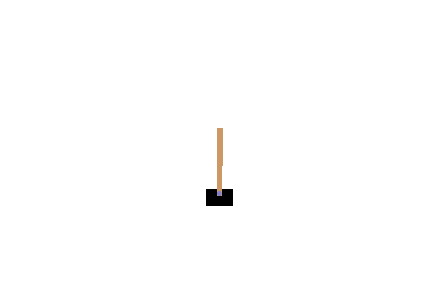
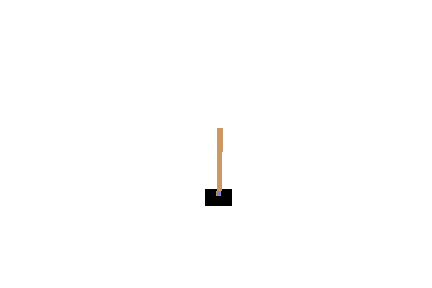
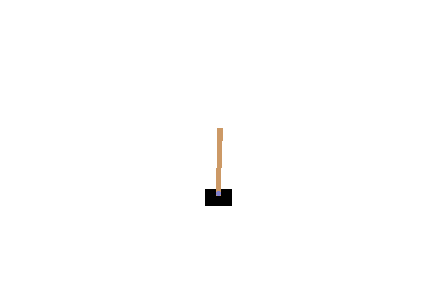
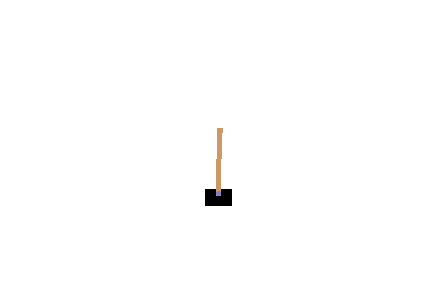
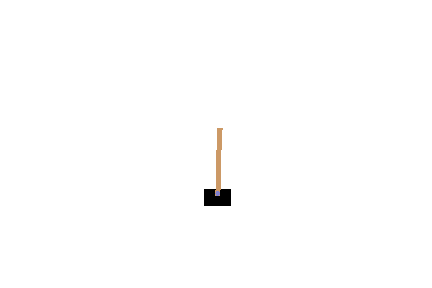
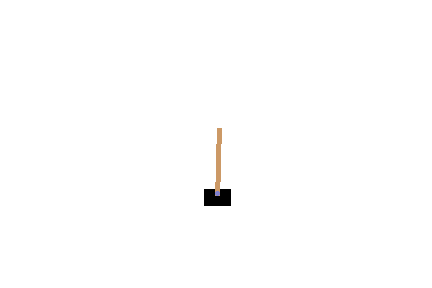
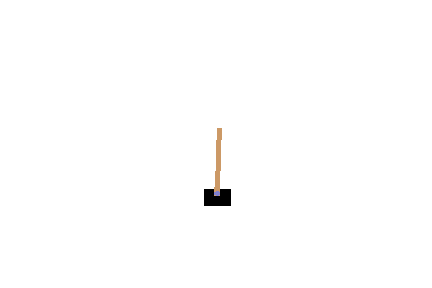
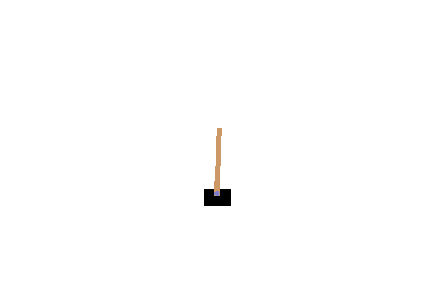
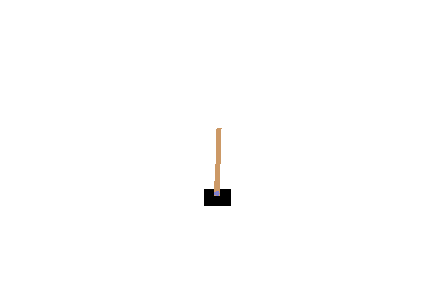
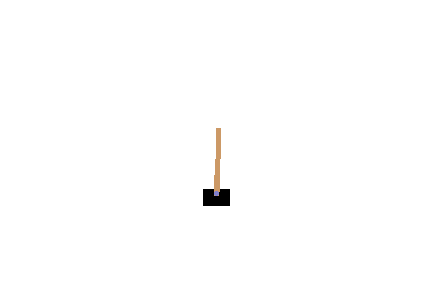
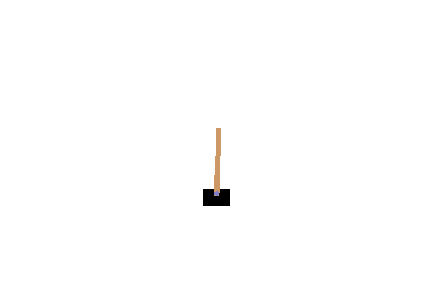
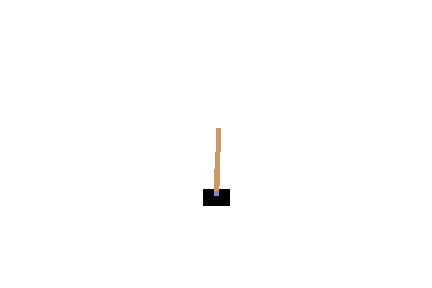
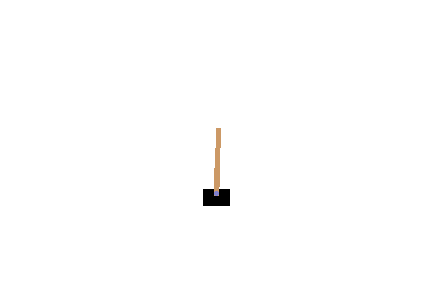
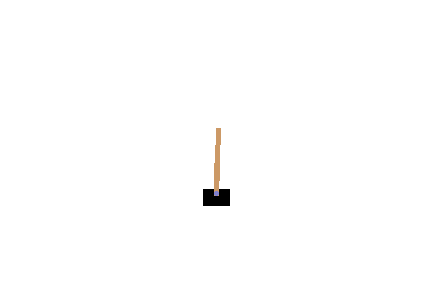
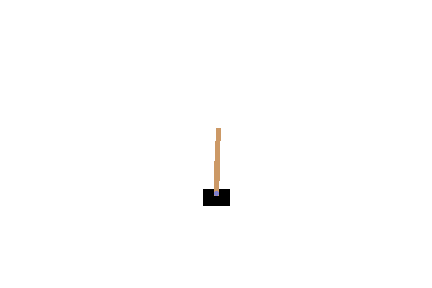
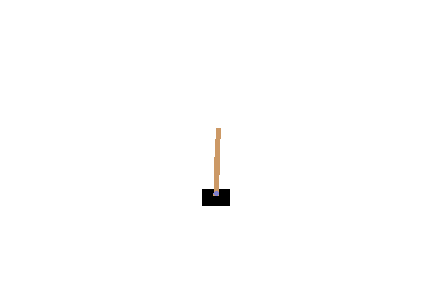
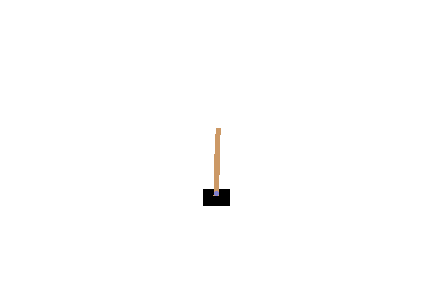
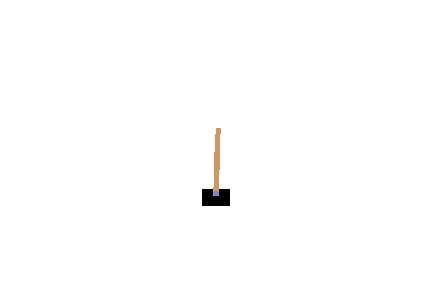
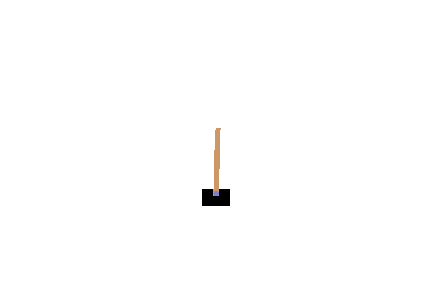
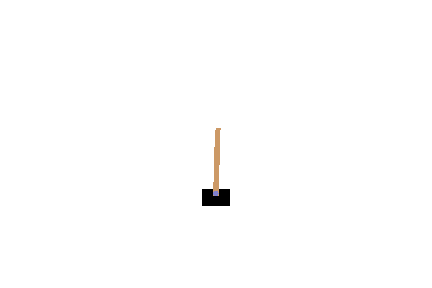
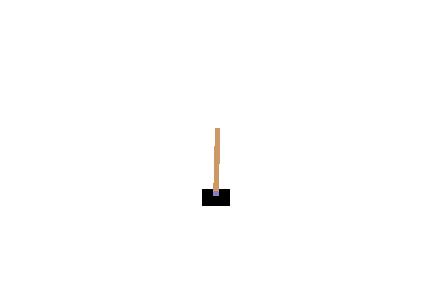
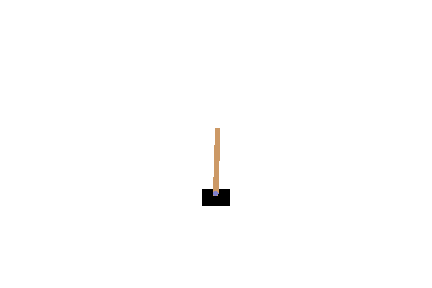
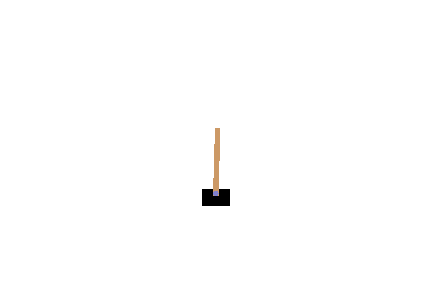
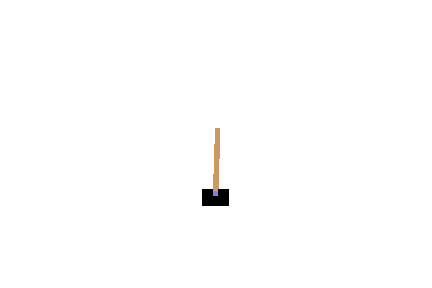
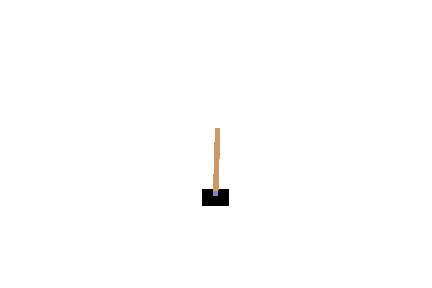
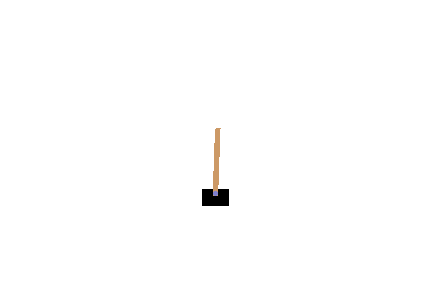
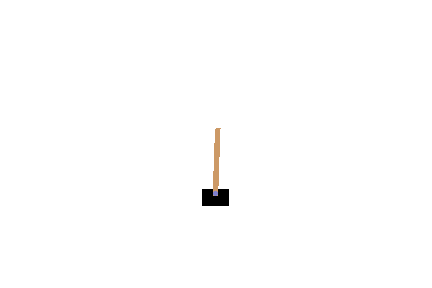
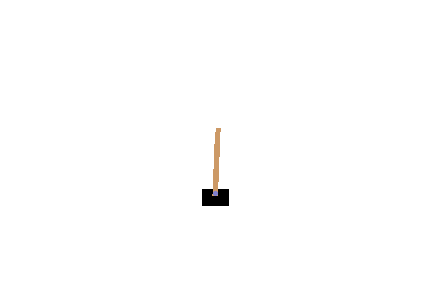
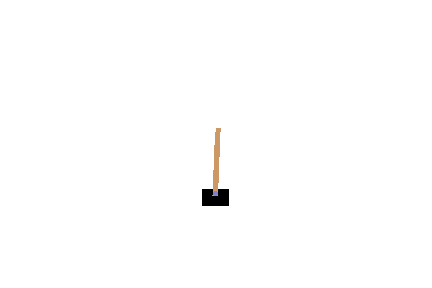
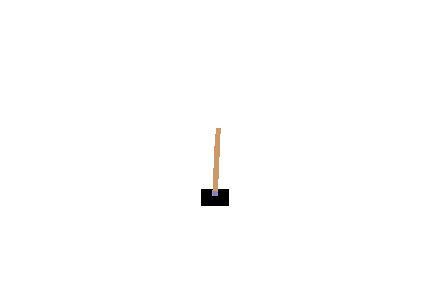
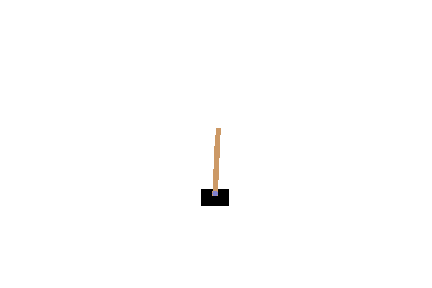
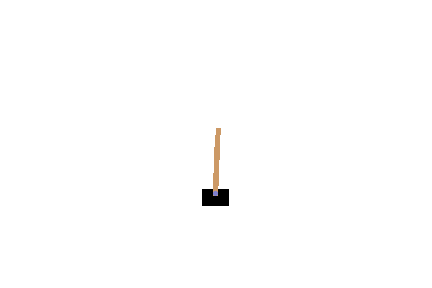
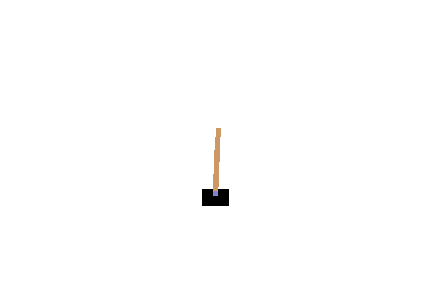
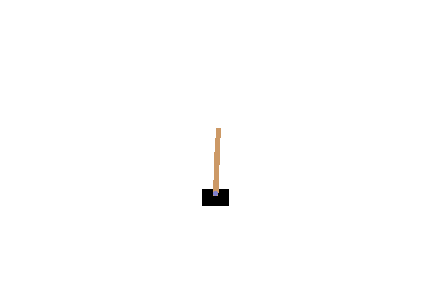
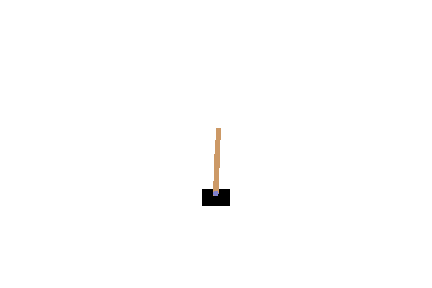
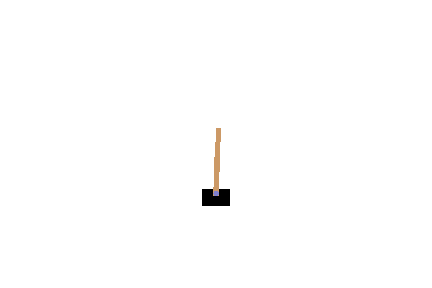
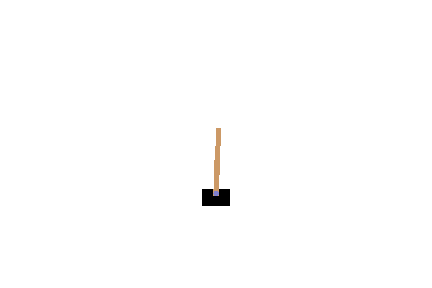
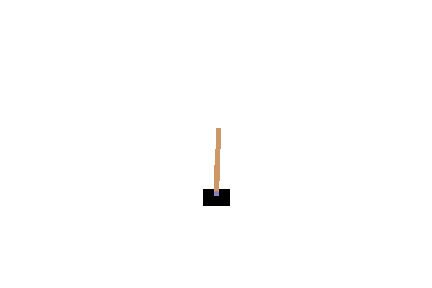
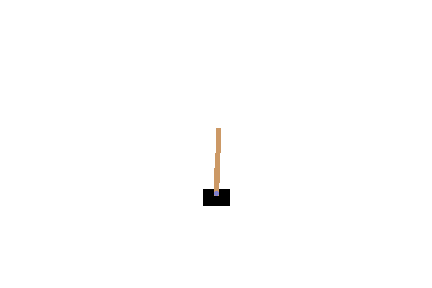
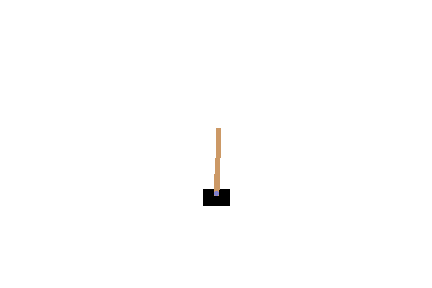
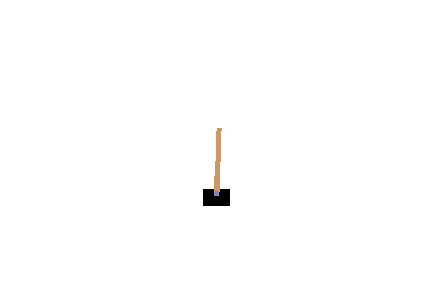
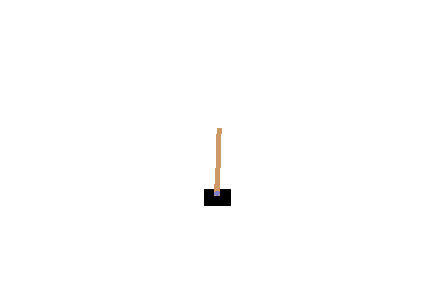
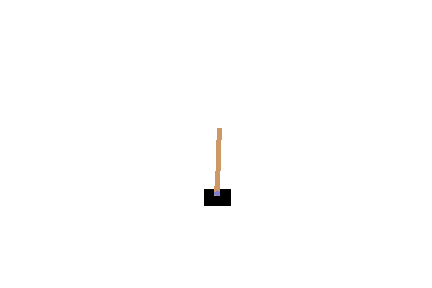
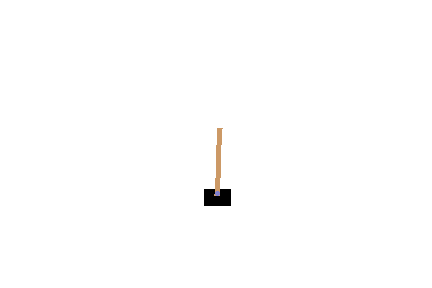
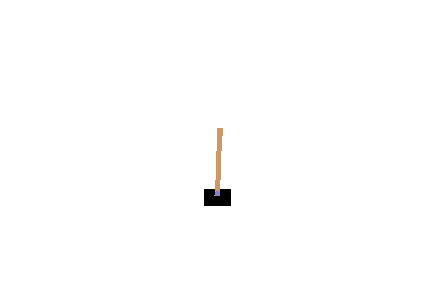
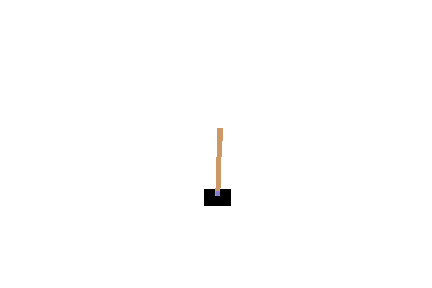
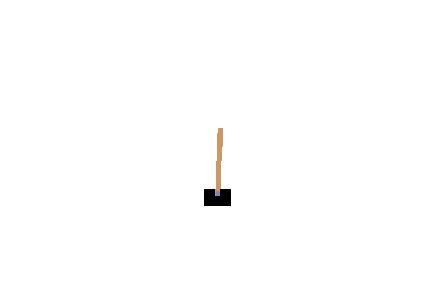
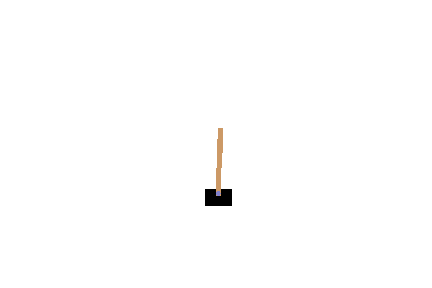
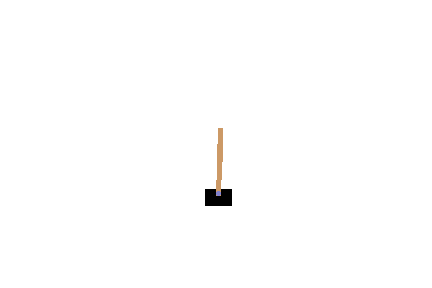
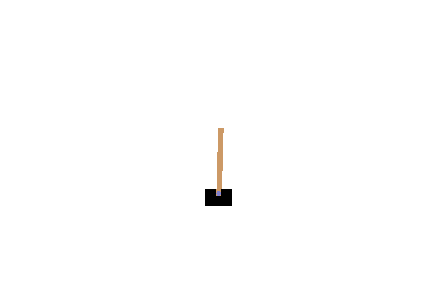
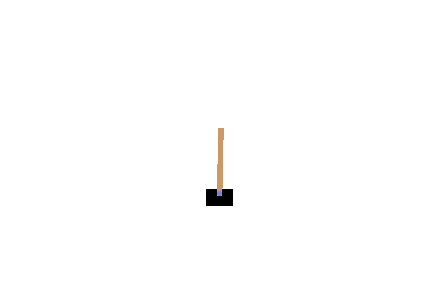
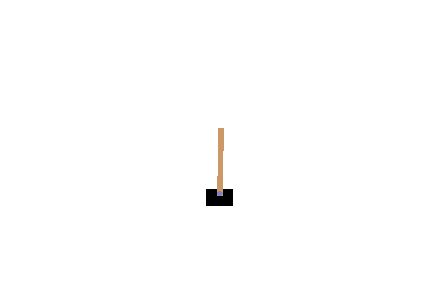
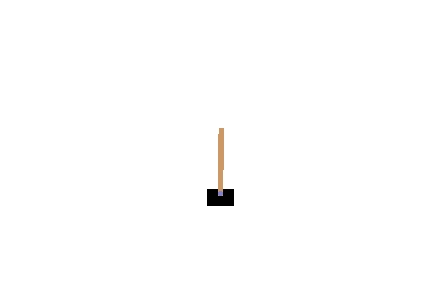
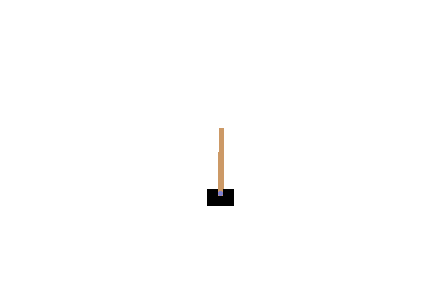
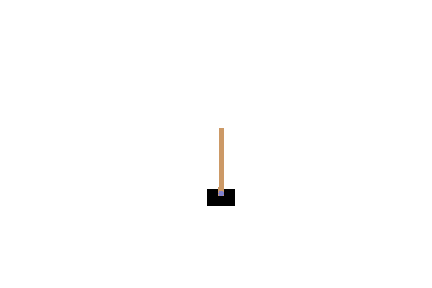
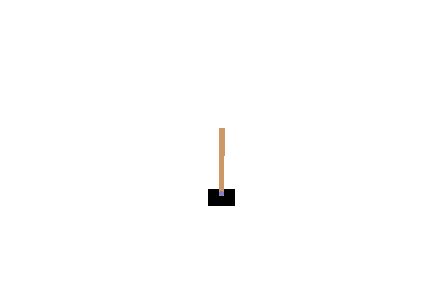
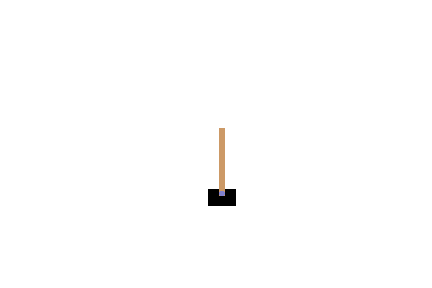
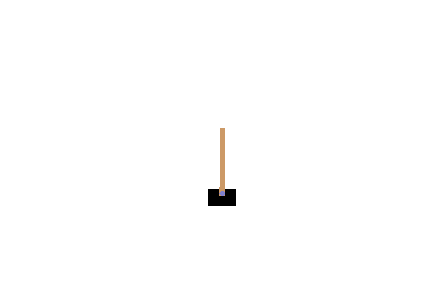
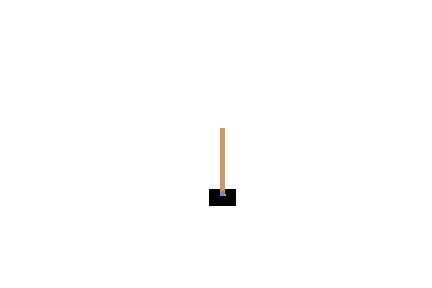
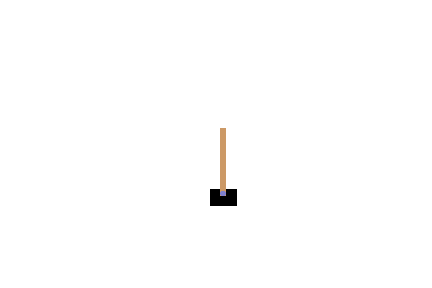
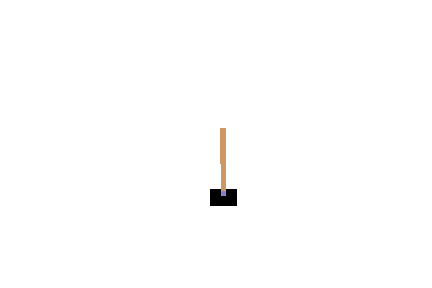
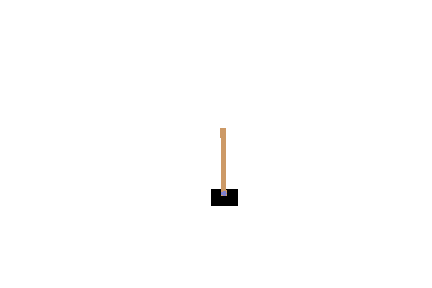
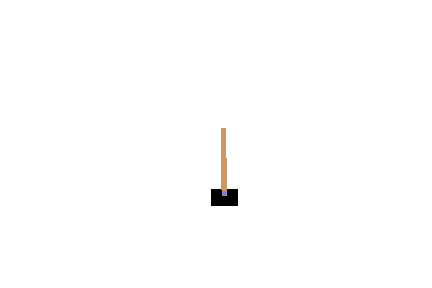
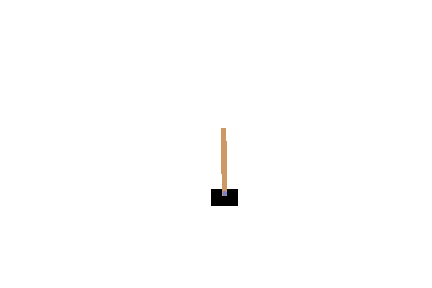
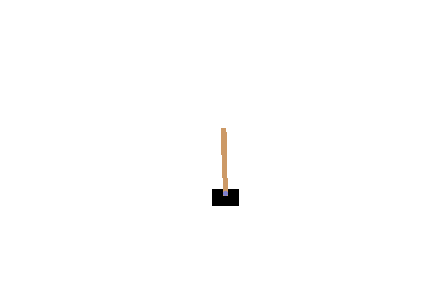
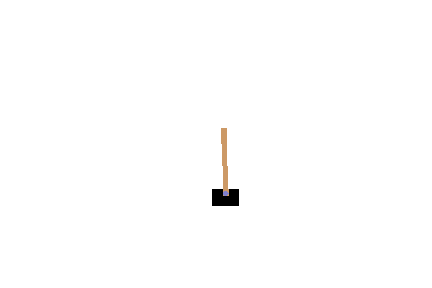
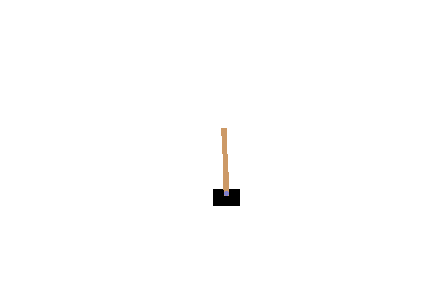
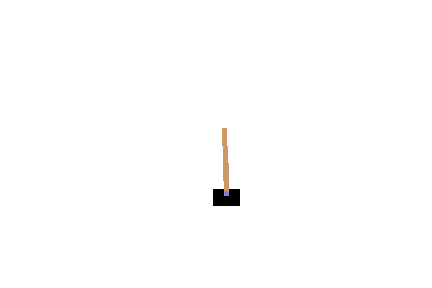
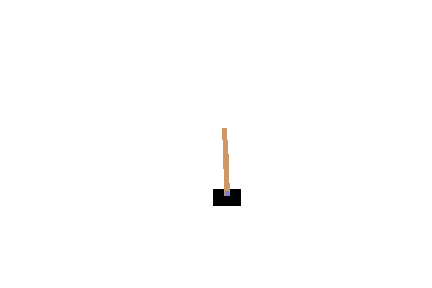
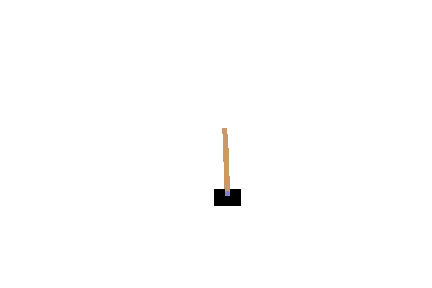
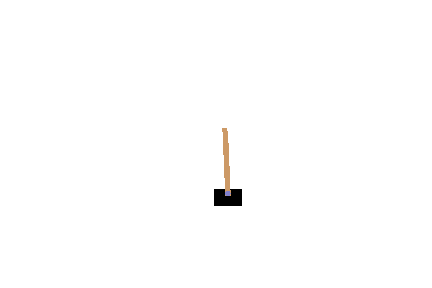
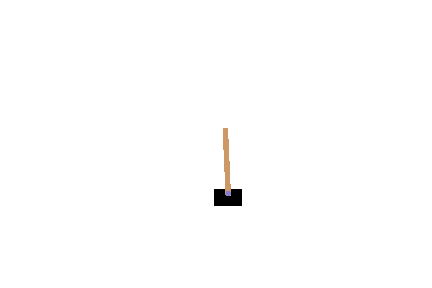
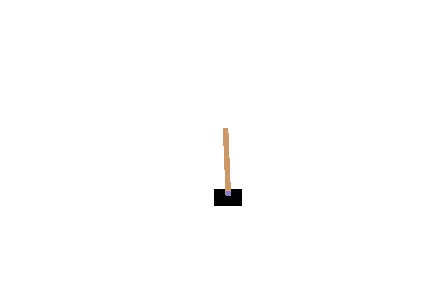
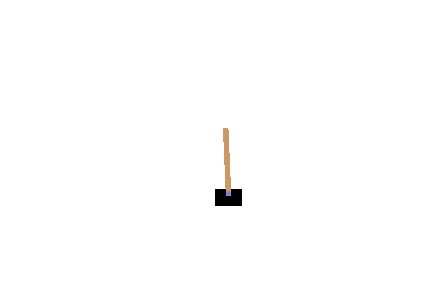
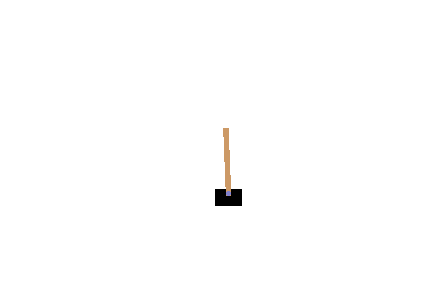
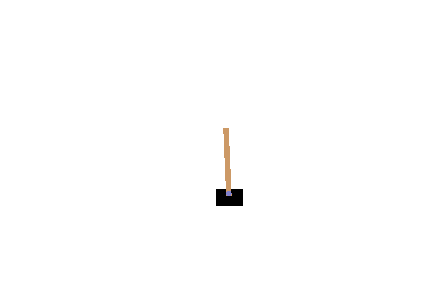
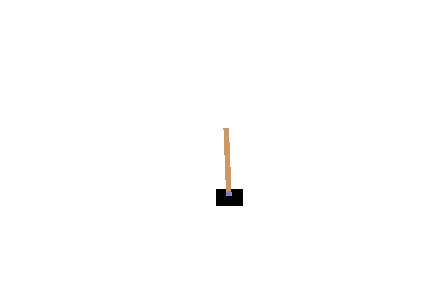
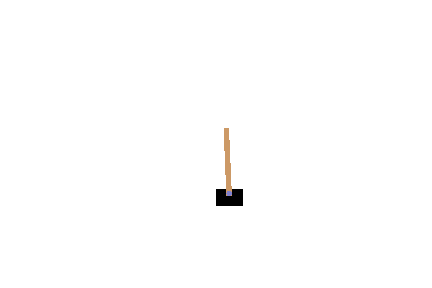
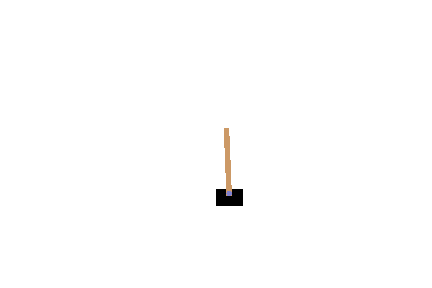
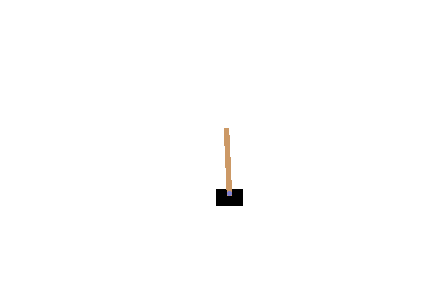
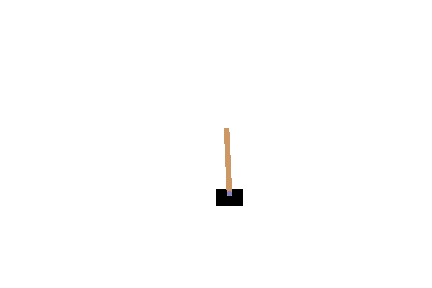
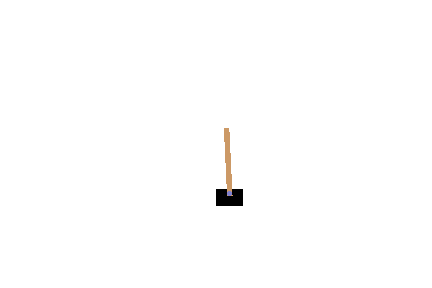
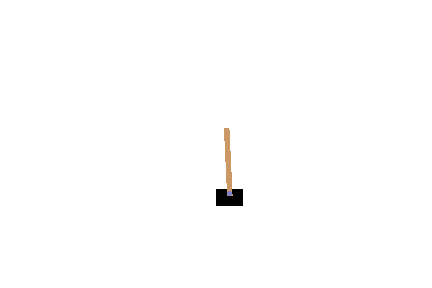
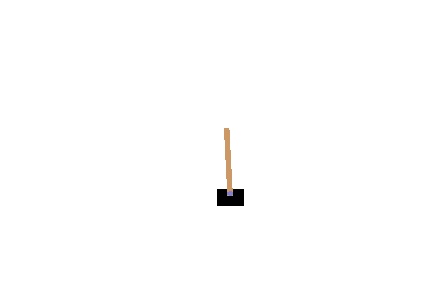
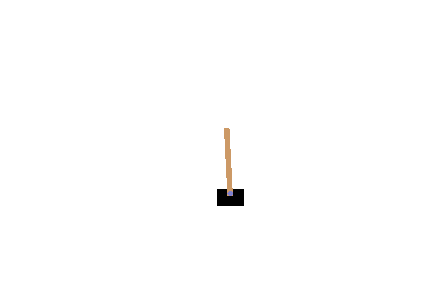
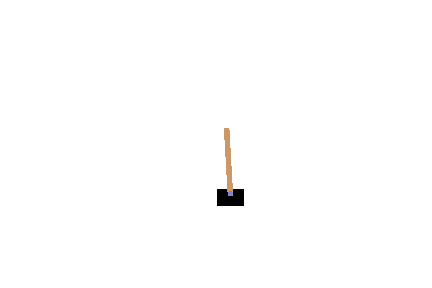
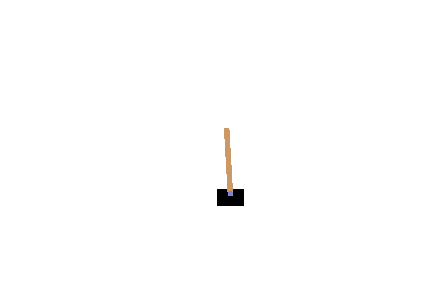
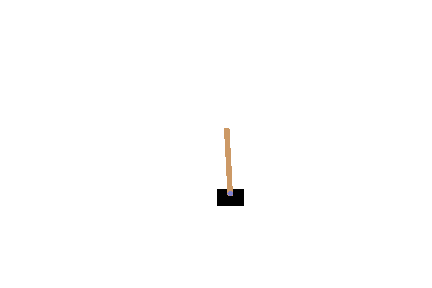
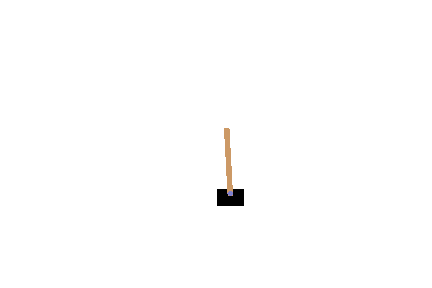
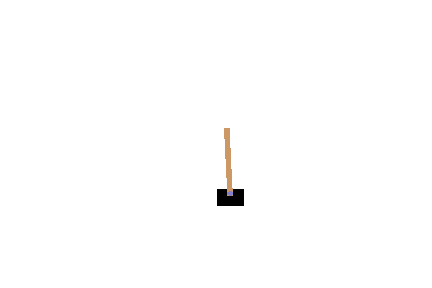
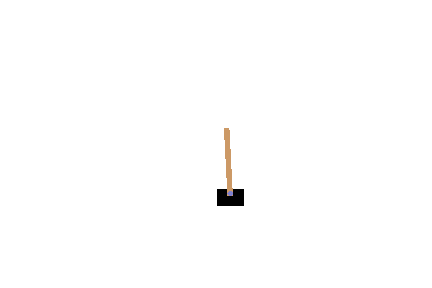
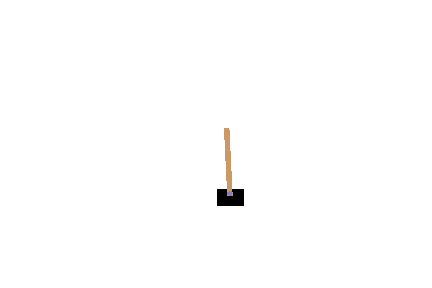
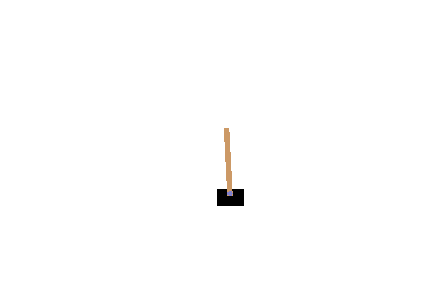
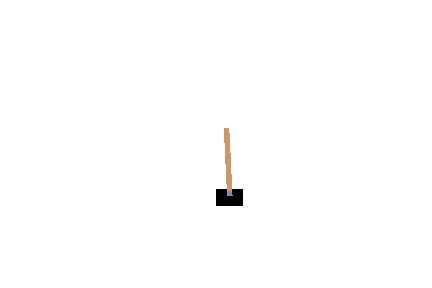
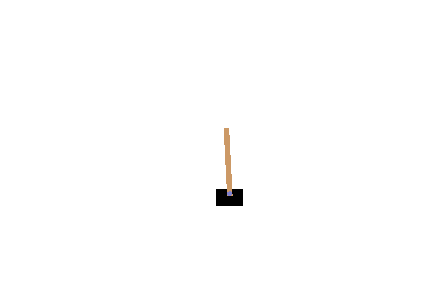
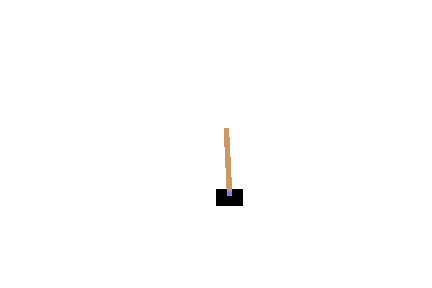
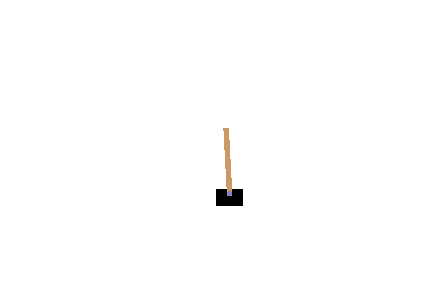
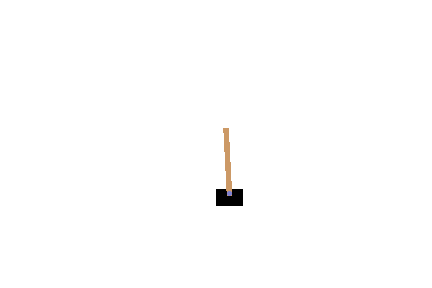
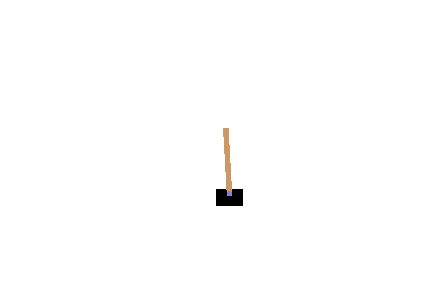
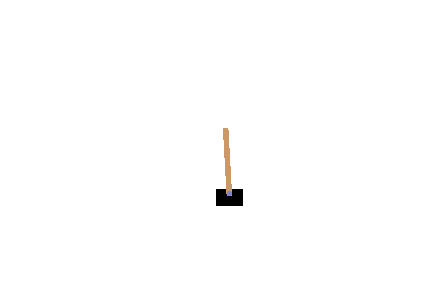
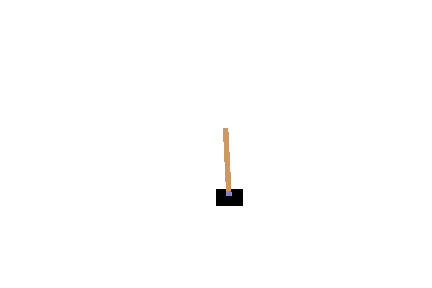
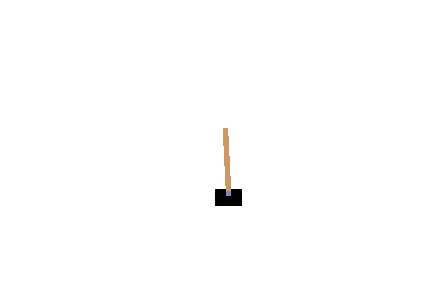
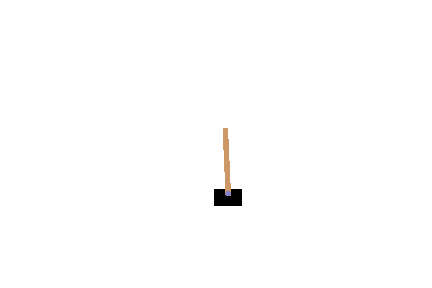
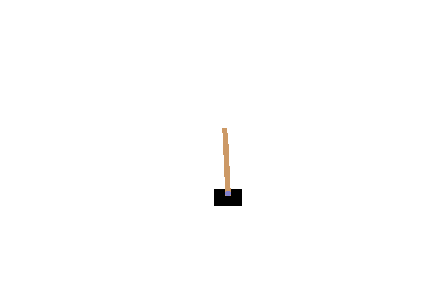
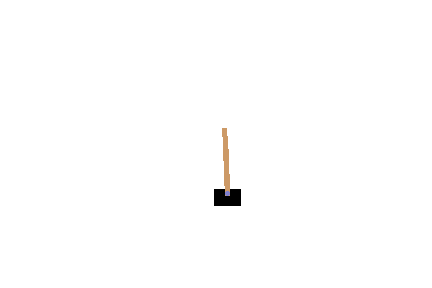
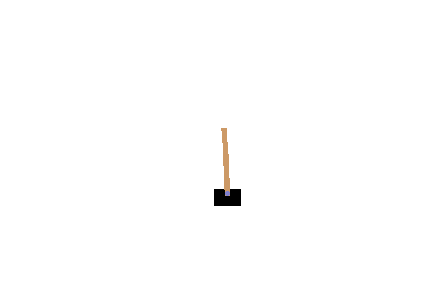
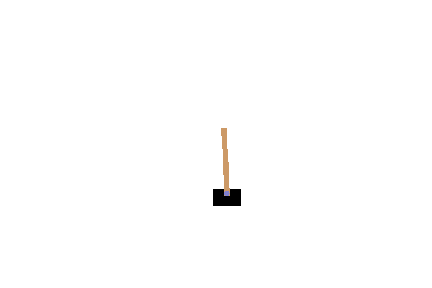
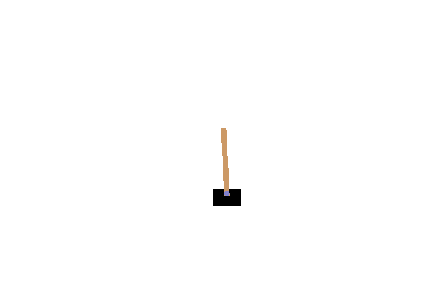
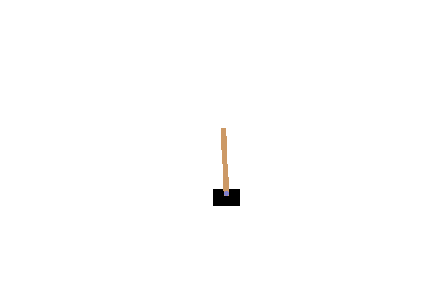
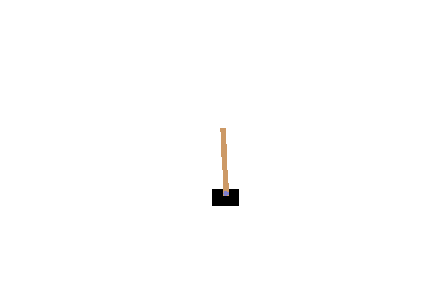
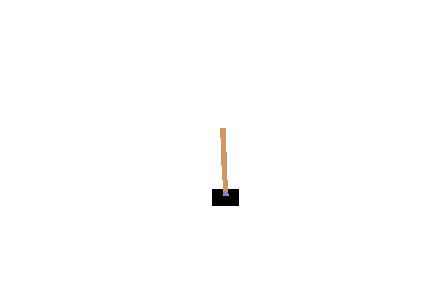
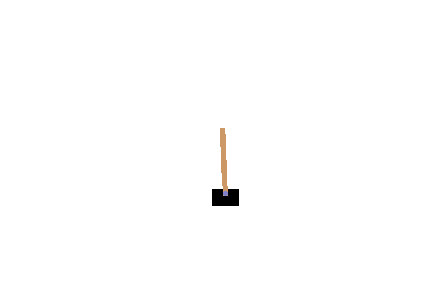
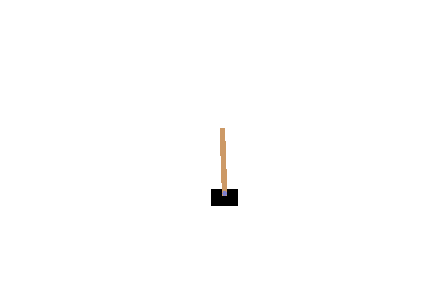
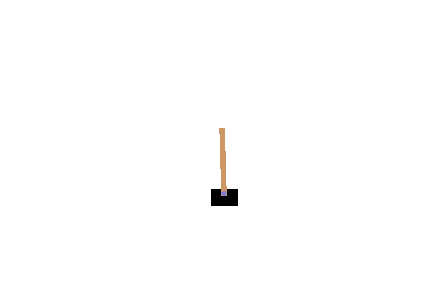
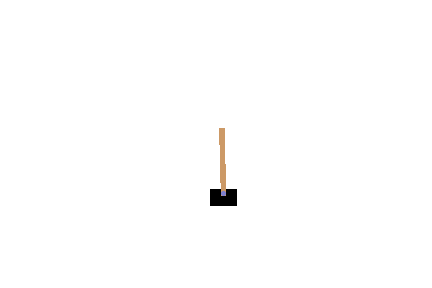

In [16]:
env = gym.make('CartPole-v0')  # I need to recreate this for render to work. No idea why.
s = env.reset()
frames = []
for i in range(200):
    frames.append(env.render(mode = 'rgb_array'))
    action = LinearDecision(s, best_weights)
    s, reward, done, _ = env.step(action)
    if done:
        break
env.close()
print(f'Total number of time-steps: {i}')
display_frames_as_gif(frames)

Other parameter search algorithms for this problems are described [in the post I linked to above](http://kvfrans.com/simple-algoritms-for-solving-cartpole/)